In [515]:
import pandas as pd
import seaborn as sns
from scipy.stats import shapiro

import random
import os
import itertools
import re

import matplotlib.pyplot as plt 
%matplotlib inline 
import numpy as np 

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# Загрузка csv-файлов истории транзакций

### Было взято 20 случайных файлов из-за нехватки памяти

In [2]:
df = pd.read_csv('C:/Users/dataset/txns_data_raw/txns_ww1.csv', sep=';')

In [3]:
list_df = {}
for i in os.listdir('C:/Users/dataset/txns_data_raw/'):
    way_to_folder = 'C:/Users/dataset/txns_data_raw/' + i
    list_df[i.replace(".csv", "")] = way_to_folder

In [4]:
keys = list(list_df.keys())

In [5]:
random.shuffle(keys)

In [6]:
list_df_shuffle = [(key, list_df[key]) for key in keys]

In [7]:
list_df_shuffle = dict(list_df_shuffle)

In [8]:
list_df_slice = dict(itertools.islice(list_df_shuffle.items(), 20))

In [9]:
dic_df = {}
for k, v in list_df_slice.items():
    dic_df[k] = pd.read_csv(v, sep=';')

In [10]:
list_conc = []
for key in list_df_slice.keys():
    list_conc.append(dic_df[key])
    
df = pd.concat(list_conc)

In [11]:
df.shape

(37530179, 12)

### Возьмем сэмплированную выборку 1 млн. значений

In [12]:
sample_df = df.sample(1000000).reset_index(drop=True)

In [13]:
main_df = sample_df.copy()

In [14]:
# Проверка типов данных для принятия решения о их сохранении и проверка наличия пустых значений
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   txn_id           1000000 non-null  int64  
 1   txn_minute       1000000 non-null  object 
 2   qw               1000000 non-null  int64  
 3   txn_type         1000000 non-null  object 
 4   product          1000000 non-null  object 
 5   cat              992022 non-null   object 
 6   amount           1000000 non-null  float64
 7   client_fee       1000000 non-null  float64
 8   payout_fee       1000000 non-null  float64
 9   interchange_fee  1000000 non-null  float64
 10  paysys_fee       1000000 non-null  float64
 11  payin_fee        1000000 non-null  float64
dtypes: float64(6), int64(2), object(4)
memory usage: 91.6+ MB


In [15]:
# Переводим в DateTime для удобства дальнейшей работы
sample_df['txn_minute'] = pd.to_datetime(sample_df.txn_minute)

In [16]:
# Описательная статистика
sample_df.describe()

,txn_id,qw,amount,client_fee,payout_fee,interchange_fee,paysys_fee,payin_fee
count,1.000000e+06,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,1.462938e+08,2.425775e+06,2562.961313,22.859271,-5.361356,2.040939,-0.835780,-5.965105
std,2.117290e+07,1.244173e+06,9353.196789,130.157034,50.468106,36.267961,13.345908,38.720909
min,1.040811e+08,1.100000e+01,17.501489,0.000000,-7175.000000,0.000000,-4349.750000,-4375.000000
25%,1.313471e+08,1.405011e+06,175.000000,0.000000,-5.000000,0.000000,-0.000000,-0.875000
50%,1.443177e+08,2.420941e+06,525.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000
75%,1.658135e+08,3.489907e+06,1750.000000,7.000000,0.000000,0.000000,0.000000,0.000000
max,1.847431e+08,4.631149e+06,875000.000000,14350.000000,262.500000,13046.250000,-0.000000,-0.000000


In [17]:
# Проверка на null
sample_df.isnull().sum()

txn_id                0
txn_minute            0
qw                    0
txn_type              0
product               0
cat                7978
amount                0
client_fee            0
payout_fee            0
interchange_fee       0
paysys_fee            0
payin_fee             0
dtype: int64

In [18]:
# Пользователи чаще всего используют киви-кошелек

sample_df['product'].value_counts()

QW                   891370
Виртуальная карта     56382
Пластиковая карта     52248
Name: product, dtype: int64

In [151]:
sample_df.head()

,txn_id,txn_minute,qw,cat,amount,client_fee,payout_fee,interchange_fee,paysys_fee,payin_fee,...,arppu_on_user,avg_txn_id,year_birth,nationality,sex,txn_type_payin,txn_type_payout,product_QW,product_Виртуальная карта,product_Пластиковая карта
0,133484189,2022-05-19 17:57:00,2080605,продукты 1,41.615,0.0,-0.0,0.624225,-1.208075,-0.000,...,1575.0000,1.0,1988.0,0.0,0.0,0,1,0,1,0
1,169123165,2022-10-17 14:32:00,2815346,переводы,1243.970,0.0,-0.0,0.000000,-0.000000,-0.000,...,351.7500,1.0,1988.0,0.0,0.0,0,1,1,0,0
2,104875603,2022-01-20 01:16:00,4603778,развлечения 1,1505.000,30.1,-0.0,0.000000,-0.000000,-0.000,...,96.2325,1.0,1988.0,0.0,0.0,0,1,1,0,0
3,127079232,2022-04-19 17:26:00,4579243,развлечения 1,752.500,0.0,-0.0,0.000000,-0.000000,-7.525,...,530.4775,1.0,2000.0,0.0,1.0,1,0,1,0,0
4,167455752,2022-10-10 18:05:00,683134,пополнения с карты,173.250,0.0,-0.0,0.000000,-0.000000,-1.386,...,65.5025,1.0,1990.0,1.0,1.0,1,0,1,0,0


# Юзеры

In [21]:
qw_personal_data = pd.read_csv('C:/Users/dataset/personal_data/qw_personal_data.csv', sep=';')

In [22]:
users = pd.pivot(qw_personal_data, values='personal_data', index='nn_qw', columns='data_type').reset_index()

In [23]:
users = users.dropna()

In [24]:
users['год рождения'] = users['год рождения'].apply(lambda x: int(x))

In [25]:
users.head()

data_type,nn_qw,год рождения,гражданство,пол
1,11,1996,РФ,м
2,13,1990,РФ,м
3,15,2004,РФ,ж
4,17,2005,РФ,ж
6,25,1979,РФ,м


In [26]:
users.describe()

data_type,nn_qw,год рождения
count,8.203020e+05,820302.000000
mean,2.458045e+06,1991.938942
std,1.131179e+06,14.361896
min,1.100000e+01,9.000000
25%,1.518110e+06,1984.000000
50%,2.431040e+06,1994.000000
75%,3.420719e+06,2002.000000
max,4.631152e+06,2017.000000


In [27]:
users = users.rename(columns={'nn_qw' : 'qw'})
users = users[users['год рождения'] > 1950]
users = users[users['год рождения'] < 2009]

In [28]:
user_birtday = users.groupby('год рождения', as_index=False) \
    .agg({'qw' : 'count'}) \
    .sort_values('qw', ascending=False)

In [29]:
user_birtday.describe()

data_type,год рождения,qw
count,58.000000,58.000000
mean,1979.500000,14096.137931
std,16.886879,11706.446578
min,1951.000000,559.000000
25%,1965.250000,2830.000000
50%,1979.500000,12218.500000
75%,1993.750000,21880.250000
max,2008.000000,43298.000000


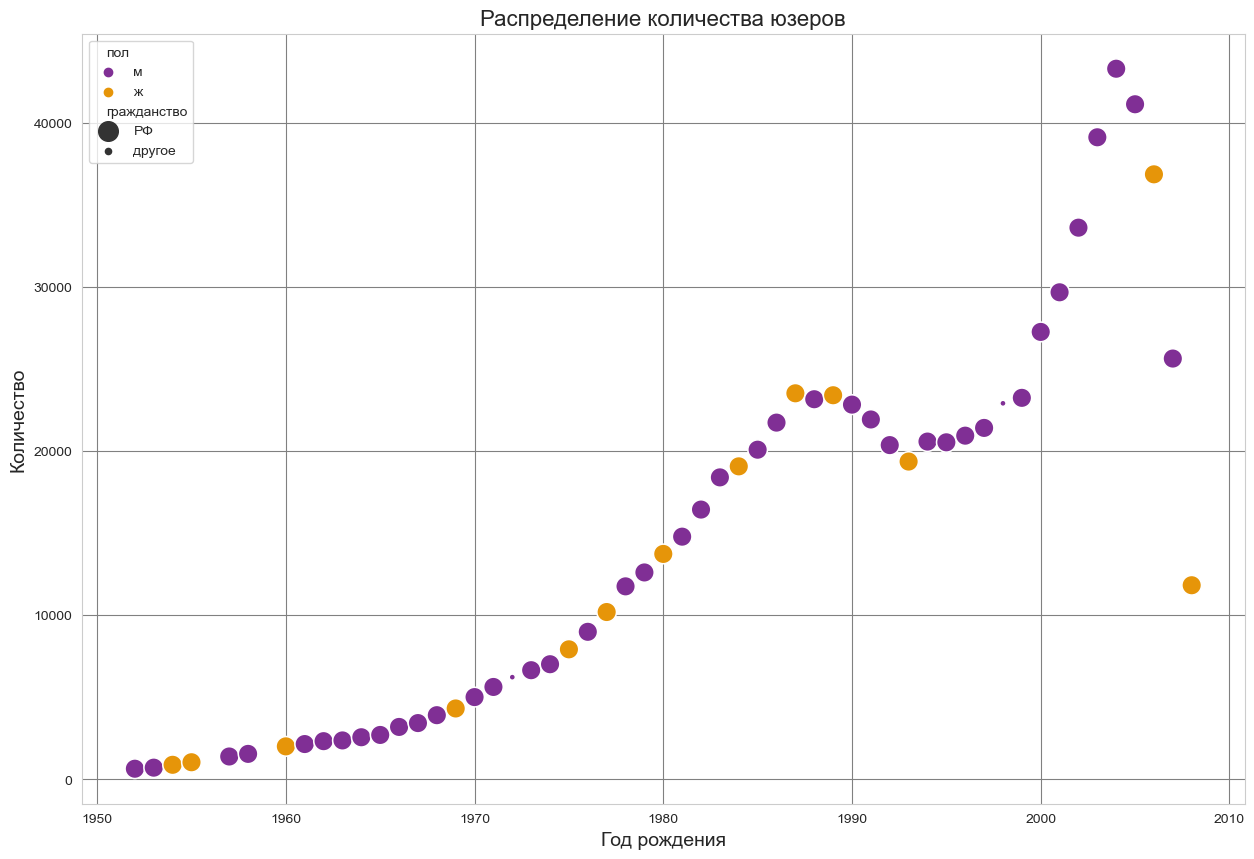

In [283]:
# В данных присутствуют ошибки, поэтому возьмем минимальный возраст юзера с 1950 года по 2009 год

plt.figure(figsize=(15,10))
plt.grid(color='grey')

sns.scatterplot(data=user_birtday, x="год рождения", y="qw", hue=users['пол'], size=users['гражданство'],
                sizes=(20, 200), legend="full", palette='CMRmap')

plt.title('Распределение количества юзеров', size=16)
plt.xlabel('Год рождения', size=14)
plt.ylabel('Количество', size=14)
plt.savefig("Распределение количества юзеров.svg")

# Метрики

### Средний платеж на юзера

In [31]:
avg_check = sample_df.groupby('qw', as_index=False) \
    .agg({'amount' : 'mean'}) \
    .rename(columns={'amount' : 'avg_amount'})

sample_df['avg_amount'] = avg_check['avg_amount']

In [32]:
# В данных содержатся много пропусков, поэтому заполним медианным значением среднего чека

sample_df['avg_amount'] = sample_df['avg_amount'].fillna(sample_df['avg_amount'].median())

### Доход по комиссиям

In [33]:
# Суммируем все комиссии
sample_df['total_fee'] = sample_df[['payout_fee','interchange_fee','paysys_fee','payin_fee','client_fee']].sum(axis=1)

### Среднее число транзакций (APC) и средний доход на платящего пользователя (ARPPU)

In [34]:
apc = sample_df.groupby('qw', as_index=False) \
    .agg({'txn_id' : 'count'}) \
    .rename(columns={'txn_id' : 'avg_txn_id'})

apc['avg_amount'] = sample_df['avg_amount']
apc['arppu_on_user'] = apc.avg_txn_id * apc.avg_amount
sample_df['arppu_on_user'] = apc['arppu_on_user']
sample_df['avg_txn_id'] = apc['avg_txn_id']

# В данных содержатся много пропусков, поэтому заполним медианным значением arppu_on_user

sample_df['arppu_on_user'] = sample_df['arppu_on_user'].fillna(sample_df['arppu_on_user'].median())
sample_df['avg_txn_id'] = sample_df['avg_txn_id'].fillna(sample_df['avg_txn_id'].median())

### М (1) / Ж (0), РФ (1) / другое (0)

In [35]:
users_binar = users.rename(columns={'nn_qw' : 'qw', 'год рождения' : 'year_birth', 'гражданство' : 'nationality',
                                    'пол' : 'sex'})
users_binar.head()

data_type,qw,year_birth,nationality,sex
1,11,1996,РФ,м
2,13,1990,РФ,м
3,15,2004,РФ,ж
4,17,2005,РФ,ж
6,25,1979,РФ,м


In [36]:
users_binar['nationality'] = users_binar['nationality'].apply(lambda x: 1 if x == 'РФ' else 0)

In [37]:
users_binar['sex'] = users_binar['sex'].apply(lambda x: 1 if x == 'м' else 0)

In [38]:
sample_df = sample_df.merge(users_binar, on='qw', how='left')

In [39]:
# Заполним Nan

sample_df['year_birth'] = sample_df['year_birth'].fillna(sample_df['year_birth'].median())
sample_df['nationality'] = sample_df['nationality'].fillna(random.randint(0, 1))
sample_df['sex'] = sample_df['sex'].fillna(random.randint(0, 1))

### Преобразуем категориальные переменные в фиктивные переменные

In [40]:
sample_df = pd.get_dummies(sample_df, columns=['txn_type', 'product'])

In [41]:
sample_df.head()

,txn_id,txn_minute,qw,cat,amount,client_fee,payout_fee,interchange_fee,paysys_fee,payin_fee,...,arppu_on_user,avg_txn_id,year_birth,nationality,sex,txn_type_payin,txn_type_payout,product_QW,product_Виртуальная карта,product_Пластиковая карта
0,133484189,2022-05-19 17:57:00,2080605,продукты 1,41.615,0.0,-0.0,0.624225,-1.208075,-0.000,...,1575.0000,1.0,1988.0,0.0,0.0,0,1,0,1,0
1,169123165,2022-10-17 14:32:00,2815346,переводы,1243.970,0.0,-0.0,0.000000,-0.000000,-0.000,...,351.7500,1.0,1988.0,0.0,0.0,0,1,1,0,0
2,104875603,2022-01-20 01:16:00,4603778,развлечения 1,1505.000,30.1,-0.0,0.000000,-0.000000,-0.000,...,96.2325,1.0,1988.0,0.0,0.0,0,1,1,0,0
3,127079232,2022-04-19 17:26:00,4579243,развлечения 1,752.500,0.0,-0.0,0.000000,-0.000000,-7.525,...,530.4775,1.0,2000.0,0.0,1.0,1,0,1,0,0
4,167455752,2022-10-10 18:05:00,683134,пополнения с карты,173.250,0.0,-0.0,0.000000,-0.000000,-1.386,...,65.5025,1.0,1990.0,1.0,1.0,1,0,1,0,0


# Model k-means

In [42]:
sample_df_for_model = sample_df.copy()

In [43]:
# Уберем лишние столбцы
sample_df_for_model = sample_df_for_model.drop(columns=['txn_id', 'txn_minute', 'qw', 'cat'])

In [44]:
sample_df_for_model.head()

,amount,client_fee,payout_fee,interchange_fee,paysys_fee,payin_fee,avg_amount,total_fee,arppu_on_user,avg_txn_id,year_birth,nationality,sex,txn_type_payin,txn_type_payout,product_QW,product_Виртуальная карта,product_Пластиковая карта
0,41.615,0.0,-0.0,0.624225,-1.208075,-0.000,1575.0000,-0.58385,1575.0000,1.0,1988.0,0.0,0.0,0,1,0,1,0
1,1243.970,0.0,-0.0,0.000000,-0.000000,-0.000,351.7500,0.00000,351.7500,1.0,1988.0,0.0,0.0,0,1,1,0,0
2,1505.000,30.1,-0.0,0.000000,-0.000000,-0.000,96.2325,30.10000,96.2325,1.0,1988.0,0.0,0.0,0,1,1,0,0
3,752.500,0.0,-0.0,0.000000,-0.000000,-7.525,530.4775,-7.52500,530.4775,1.0,2000.0,0.0,1.0,1,0,1,0,0
4,173.250,0.0,-0.0,0.000000,-0.000000,-1.386,65.5025,-1.38600,65.5025,1.0,1990.0,1.0,1.0,1,0,1,0,0


In [45]:
sample_df_for_model.isnull().sum()

amount                       0
client_fee                   0
payout_fee                   0
interchange_fee              0
paysys_fee                   0
payin_fee                    0
avg_amount                   0
total_fee                    0
arppu_on_user                0
avg_txn_id                   0
year_birth                   0
nationality                  0
sex                          0
txn_type_payin               0
txn_type_payout              0
product_QW                   0
product_Виртуальная карта    0
product_Пластиковая карта    0
dtype: int64

In [46]:
# Проведем предпроцессинг
mms = MinMaxScaler()
mms.fit(sample_df_for_model)
data_transformed = mms.transform(sample_df_for_model)

In [47]:
Sum_of_squared_distances = []
K = range(2, 12, 1)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

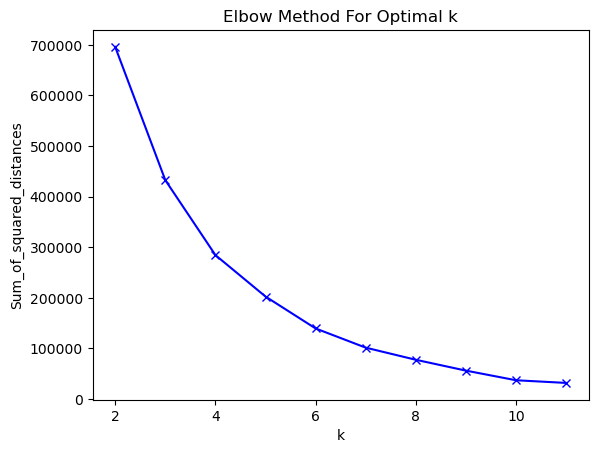

In [48]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

# Оптимально 4 кластера

In [49]:
# заново обучим модель с 4 кластерами
kmeans = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)

In [50]:
y_pred = kmeans.fit_predict(data_transformed)

In [51]:
y_pred

array([0, 0, 0, ..., 2, 3, 0])

In [52]:
len(y_pred)

1000000

# Сегментация

In [53]:
# Создадим отдельный df для подсчета метрик по сегментам
segments = main_df.copy()

In [54]:
segments['cluster'] = y_pred

In [55]:
segments['cluster'].value_counts()

0    327865
3    309935
1    223235
2    138965
Name: cluster, dtype: int64

In [56]:
# Добавим нужные колонки
segments['sex'] =  sample_df['sex']
segments['nationality'] = sample_df['nationality']
segments['year_birth'] = sample_df['year_birth']
segments['total_fee'] = sample_df['total_fee']

In [57]:
segments.head()

,txn_id,txn_minute,qw,txn_type,product,cat,amount,client_fee,payout_fee,interchange_fee,paysys_fee,payin_fee,cluster,sex,nationality,year_birth,total_fee
0,133484189,2022-05-19 17:57:00,2080605,payout,Виртуальная карта,продукты 1,41.615,0.0,-0.0,0.624225,-1.208075,-0.000,0,0.0,0.0,1988.0,-0.58385
1,169123165,2022-10-17 14:32:00,2815346,payout,QW,переводы,1243.970,0.0,-0.0,0.000000,-0.000000,-0.000,0,0.0,0.0,1988.0,0.00000
2,104875603,2022-01-20 01:16:00,4603778,payout,QW,развлечения 1,1505.000,30.1,-0.0,0.000000,-0.000000,-0.000,0,0.0,0.0,1988.0,30.10000
3,127079232,2022-04-19 17:26:00,4579243,payin,QW,развлечения 1,752.500,0.0,-0.0,0.000000,-0.000000,-7.525,2,1.0,0.0,2000.0,-7.52500
4,167455752,2022-10-10 18:05:00,683134,payin,QW,пополнения с карты,173.250,0.0,-0.0,0.000000,-0.000000,-1.386,2,1.0,1.0,1990.0,-1.38600


### Описательная статистика каждого сегмента

In [58]:
segments.query('cluster == 3').describe()

,txn_id,qw,amount,client_fee,payout_fee,interchange_fee,paysys_fee,payin_fee,cluster,sex,nationality,year_birth,total_fee
count,3.099350e+05,3.099350e+05,309935.000000,309935.000000,309935.000000,309935.000000,309935.000000,309935.0,309935.0,309935.000000,309935.000000,309935.000000,309935.000000
mean,1.480471e+08,2.464731e+06,2079.966252,30.787098,-6.650407,4.268773,-1.741549,0.0,3.0,0.814881,0.997812,1987.458225,26.663915
std,2.114301e+07,1.098739e+06,8879.306353,139.250882,51.232100,53.032427,19.237568,0.0,0.0,0.388395,0.046720,10.864863,113.827593
min,1.040814e+08,1.100000e+01,17.501489,0.000000,-7175.000000,0.000000,-4349.750000,-0.0,3.0,0.000000,0.000000,1951.000000,-98.029680
25%,1.323794e+08,1.542111e+06,175.000000,0.000000,-5.000000,0.000000,-0.000000,-0.0,3.0,1.000000,1.000000,1981.000000,0.000000
50%,1.456154e+08,2.419680e+06,457.310000,3.500000,0.000000,0.000000,0.000000,0.0,3.0,1.000000,1.000000,1988.000000,3.500000
75%,1.667692e+08,3.405771e+06,1512.000000,17.500000,-0.000000,0.000000,-0.000000,-0.0,3.0,1.000000,1.000000,1995.000000,17.150000
max,1.847431e+08,4.630643e+06,875000.000000,14350.000000,105.000000,13046.250000,-0.000000,-0.0,3.0,1.000000,1.000000,2008.000000,10635.000000


In [59]:
segments.query('cluster == 2').describe()

,txn_id,qw,amount,client_fee,payout_fee,interchange_fee,paysys_fee,payin_fee,cluster,sex,nationality,year_birth,total_fee
count,1.389650e+05,1.389650e+05,138965.000000,138965.0,138965.0,138965.0,138965.0,138965.000000,138965.0,138965.0,138965.000000,138965.000000,138965.000000
mean,1.479357e+08,2.470247e+06,2962.745756,0.0,0.0,0.0,0.0,-16.991411,2.0,1.0,0.974576,1988.637736,-16.991411
std,2.135700e+07,1.115807e+06,7441.426777,0.0,0.0,0.0,0.0,60.302725,0.0,0.0,0.157409,10.620602,60.302725
min,1.040811e+08,3.190000e+02,17.517500,0.0,-0.0,0.0,-0.0,-3568.748925,2.0,1.0,0.000000,1951.000000,-3568.748925
25%,1.321661e+08,1.542721e+06,254.625000,0.0,0.0,0.0,0.0,-8.750000,2.0,1.0,1.000000,1982.000000,-8.750000
50%,1.456444e+08,2.440745e+06,848.750000,0.0,0.0,0.0,0.0,-2.325750,2.0,1.0,1.000000,1989.000000,-2.325750
75%,1.667882e+08,3.423163e+06,2625.000000,0.0,0.0,0.0,0.0,-0.700000,2.0,1.0,1.000000,1996.000000,-0.700000
max,1.847431e+08,4.631120e+06,435750.000000,0.0,-0.0,0.0,-0.0,-0.018025,2.0,1.0,1.000000,2008.000000,-0.018025


In [60]:
segments.query('cluster == 1').describe()

,txn_id,qw,amount,client_fee,payout_fee,interchange_fee,paysys_fee,payin_fee,cluster,sex,nationality,year_birth,total_fee
count,2.232350e+05,2.232350e+05,223235.000000,223235.0,223235.0,223235.0,223235.0,223235.000000,223235.0,223235.0,223235.000000,223235.00000,223235.000000
mean,1.446040e+08,2.374767e+06,2709.248827,0.0,0.0,0.0,0.0,-16.143947,1.0,0.0,0.129962,1987.70252,-16.143947
std,2.116044e+07,1.339573e+06,7972.584101,0.0,0.0,0.0,0.0,64.588415,0.0,0.0,0.336262,4.34807,64.588415
min,1.040814e+08,1.700000e+01,17.510500,0.0,-0.0,0.0,-0.0,-4375.000000,1.0,0.0,0.000000,1951.00000,-4375.000000
25%,1.276357e+08,1.241564e+06,183.128750,0.0,-0.0,0.0,-0.0,-7.875000,1.0,0.0,0.000000,1988.00000,-7.875000
50%,1.432083e+08,2.407015e+06,679.000000,0.0,0.0,0.0,0.0,-2.141300,1.0,0.0,0.000000,1988.00000,-2.141300
75%,1.633941e+08,3.528572e+06,2138.500000,0.0,-0.0,0.0,-0.0,-0.700000,1.0,0.0,0.000000,1988.00000,-0.700000
max,1.847429e+08,4.631149e+06,437500.000000,0.0,-0.0,0.0,-0.0,-0.000000,1.0,0.0,1.000000,2008.00000,0.000000


In [61]:
segments.query('cluster == 0').describe()

,txn_id,qw,amount,client_fee,payout_fee,interchange_fee,paysys_fee,payin_fee,cluster,sex,nationality,year_birth,total_fee
count,3.278650e+05,3.278650e+05,327865.00000,327865.000000,327865.000000,327865.000000,327865.000000,327865.0,327865.0,327865.000000,327865.0,327865.000000,327865.000000
mean,1.450909e+08,2.404830e+06,2750.49135,40.618155,-10.065613,2.189611,-0.902851,0.0,0.0,0.016382,0.0,1987.992332,31.839301
std,2.095453e+07,1.351360e+06,11189.64012,179.966319,72.331900,36.660186,13.851212,0.0,0.0,0.126939,0.0,1.388394,132.879978
min,1.040811e+08,2.000000e+01,17.51750,0.000000,-4375.000000,0.000000,-2083.284450,-0.0,0.0,0.000000,0.0,1951.000000,-159.770240
25%,1.281122e+08,1.267295e+06,175.00000,0.000000,-5.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,1988.000000,0.000000
50%,1.437183e+08,2.419956e+06,437.50000,3.500000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,1988.000000,2.497250
75%,1.634544e+08,3.582103e+06,1652.00000,17.500000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,1988.000000,16.000000
max,1.847431e+08,4.631149e+06,803250.00000,8750.000000,262.500000,5021.625000,-0.000000,-0.0,0.0,1.000000,0.0,2007.000000,8745.000000


## Посмотрим на статистику сегментов с положительной выручкой

In [62]:
best_clusters = segments.query('total_fee > 0')

In [63]:
best_clusters['txn_minute'] = pd.to_datetime(best_clusters.txn_minute)
best_clusters['month'] = best_clusters['txn_minute'].dt.to_period("M")
best_clusters['number_month'] = best_clusters['month'].dt.month

C:\Users\Рома\AppData\Local\Temp\ipykernel_7064\2324767663.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_clusters['txn_minute'] = pd.to_datetime(best_clusters.txn_minute)
C:\Users\Рома\AppData\Local\Temp\ipykernel_7064\2324767663.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_clusters['month'] = best_clusters['txn_minute'].dt.to_period("M")
C:\Users\Рома\AppData\Local\Temp\ipykernel_7064\2324767663.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

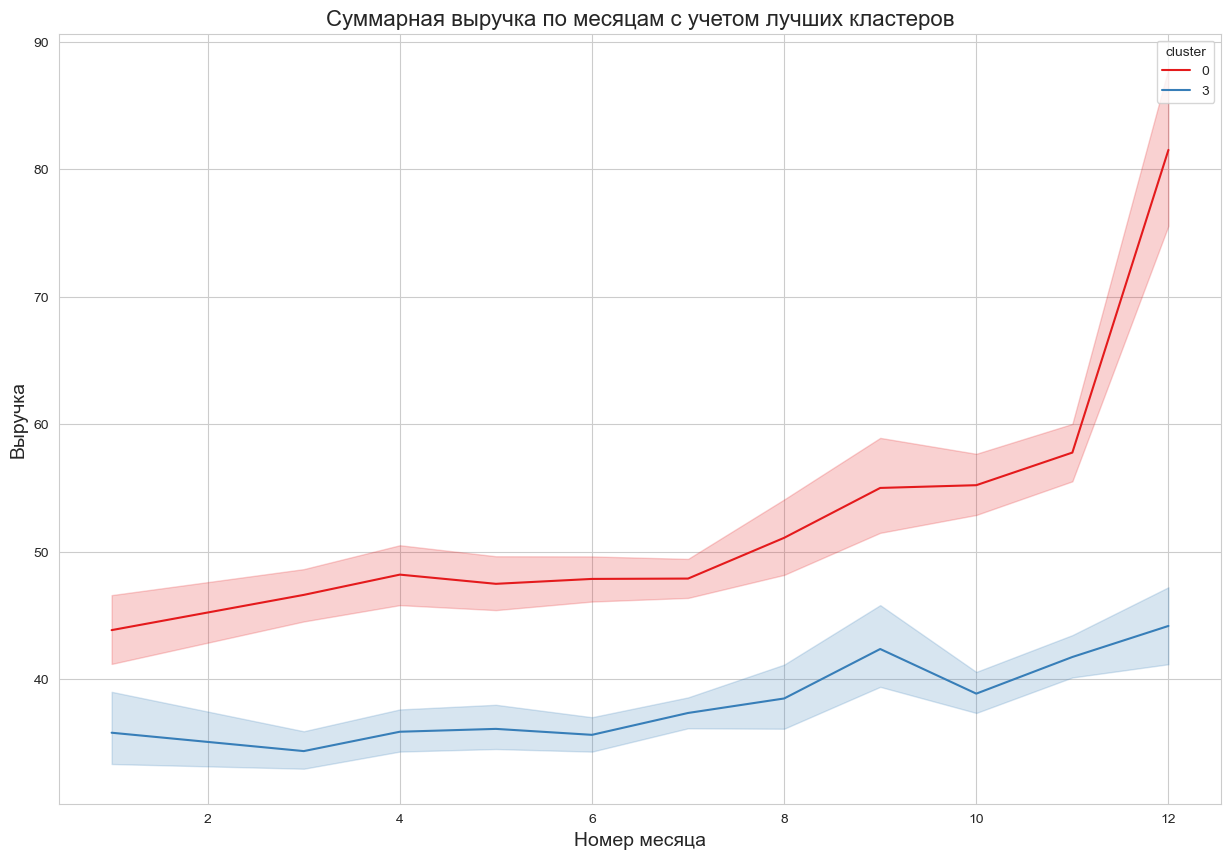

In [1035]:
plt.figure(figsize=(15,10))

sns.lineplot(data=best_clusters, x='number_month', y='total_fee', hue="cluster", palette = "Set1")

plt.title('Суммарная выручка по месяцам с учетом лучших кластеров', size=16)
plt.xlabel('Номер месяца', size=14)
plt.ylabel('Выручка', size=14)
plt.savefig("Суммарная выручка по месяцам с учетом лучших кластеров.svg")

## Статистика снятий / пополнений

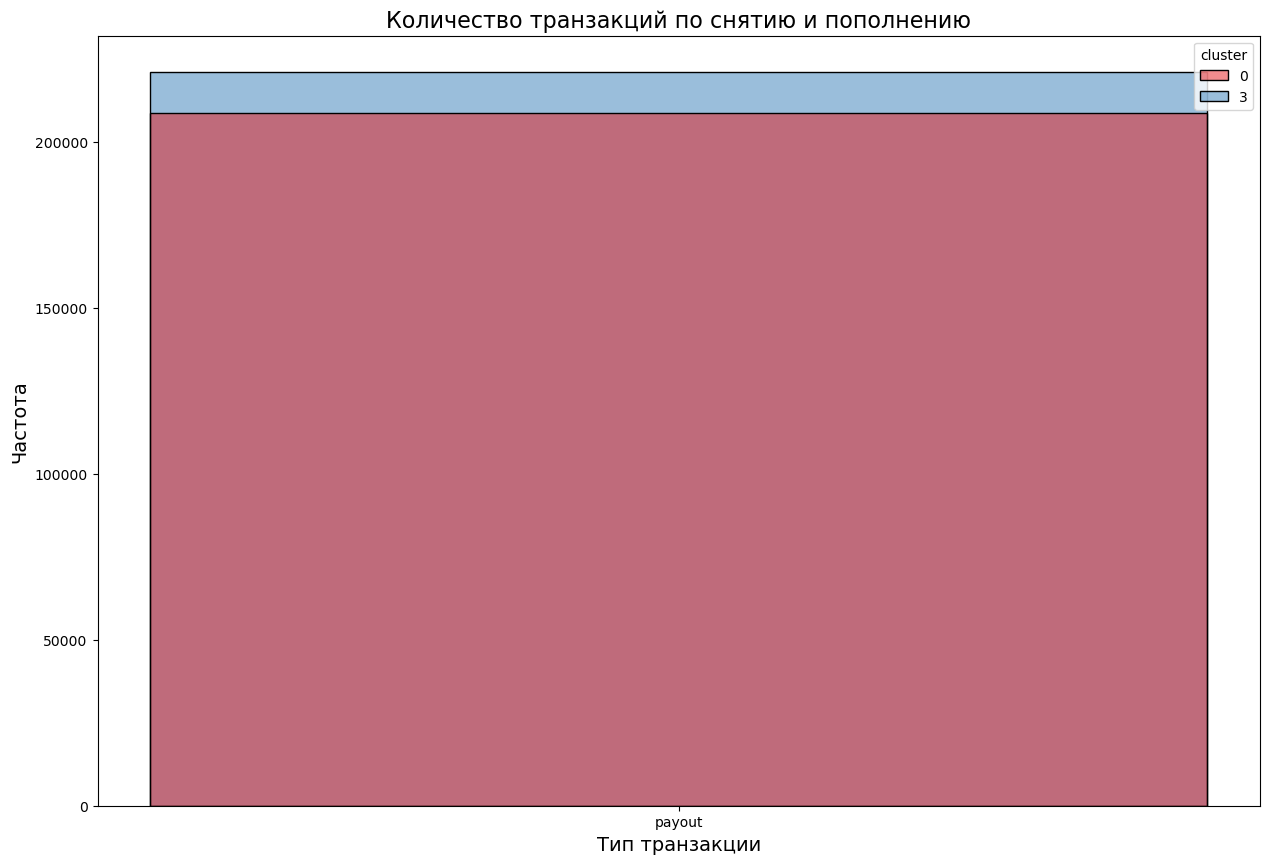

In [65]:
plt.figure(figsize=(15,10))

sns.histplot(data=best_clusters, x='txn_type', hue="cluster", palette = "Set1")

plt.title('Количество транзакций по снятию и пополнению', size=16)
plt.xlabel('Тип транзакции', size=14)
plt.ylabel('Частота', size=14)
plt.savefig("Количество транзакций по снятию и пополнению для наших сегментов.svg")

Инсайт: сегменты 0 и 3, с которых мы получили положительную выручку, всегда снимали деньги, поэтому мы получили такое распределение частоты транзакций. В то время как другие сегменты (1 и 2) пополняли и снимали примерно одинаково

In [66]:
best_clusters['product'].value_counts()

QW                   340973
Виртуальная карта     45724
Пластиковая карта     42903
Name: product, dtype: int64

# Метрики для каждого сегмента

In [533]:
# Количество юзеров по сегментам в %

clusters_0_to_3 = ((segments.cluster.value_counts(normalize=True) * 100).round(2)).to_frame().reset_index() \
    .rename(columns={'index' : 'cluster', 'cluster' : 'percent'})

clusters_0_to_3

,cluster,percent
0,0,32.79
1,3,30.99
2,1,22.32
3,2,13.90


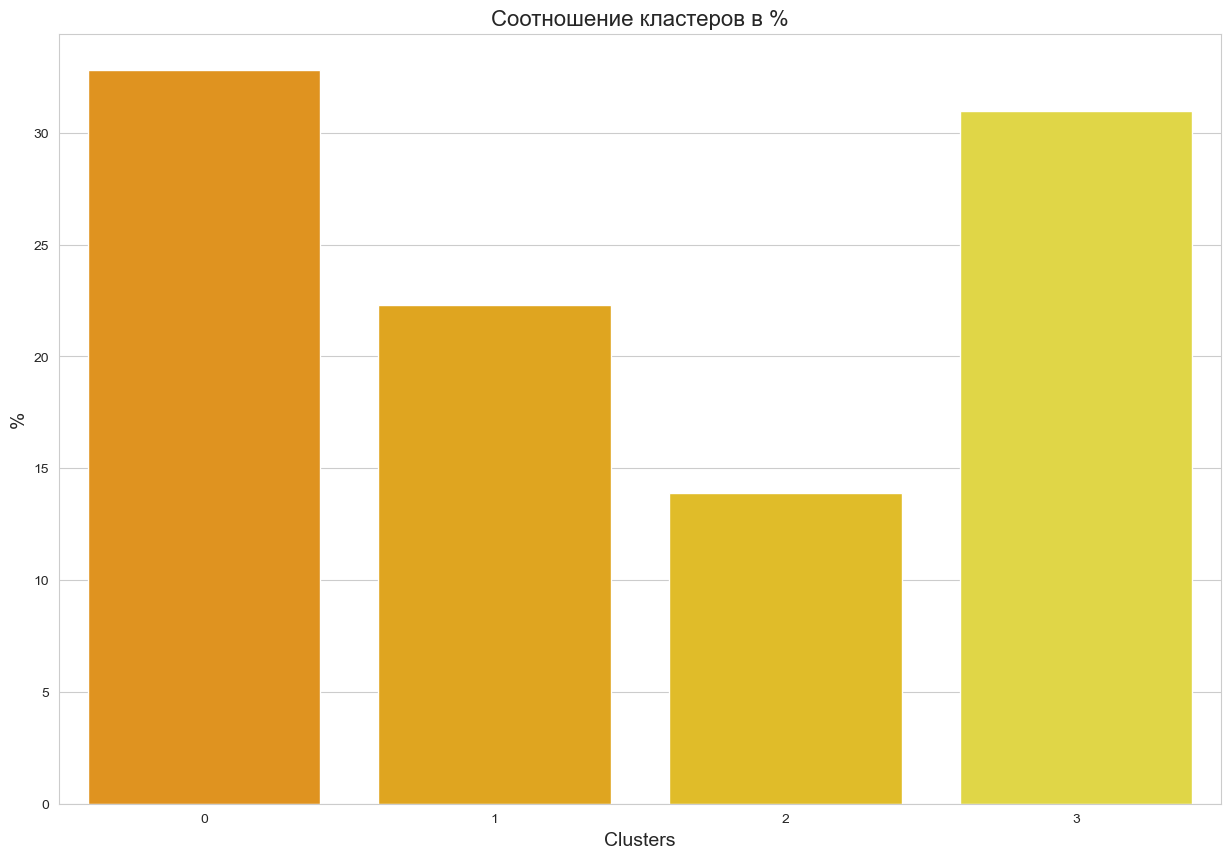

In [532]:
plt.figure(figsize=(15,10))

sns.set_style('whitegrid')
sns.barplot(x="cluster", y="percent", data=clusters_0_to_3, palette="Wistia_r")

plt.title('Соотношение кластеров в %', size=16)
plt.xlabel('Clusters', size=14)
plt.ylabel('%', size=14)
plt.savefig("Соотношение кластеров в %.svg")

## Сегмент №0

In [69]:
segment_0 = segments.query('cluster == 0')

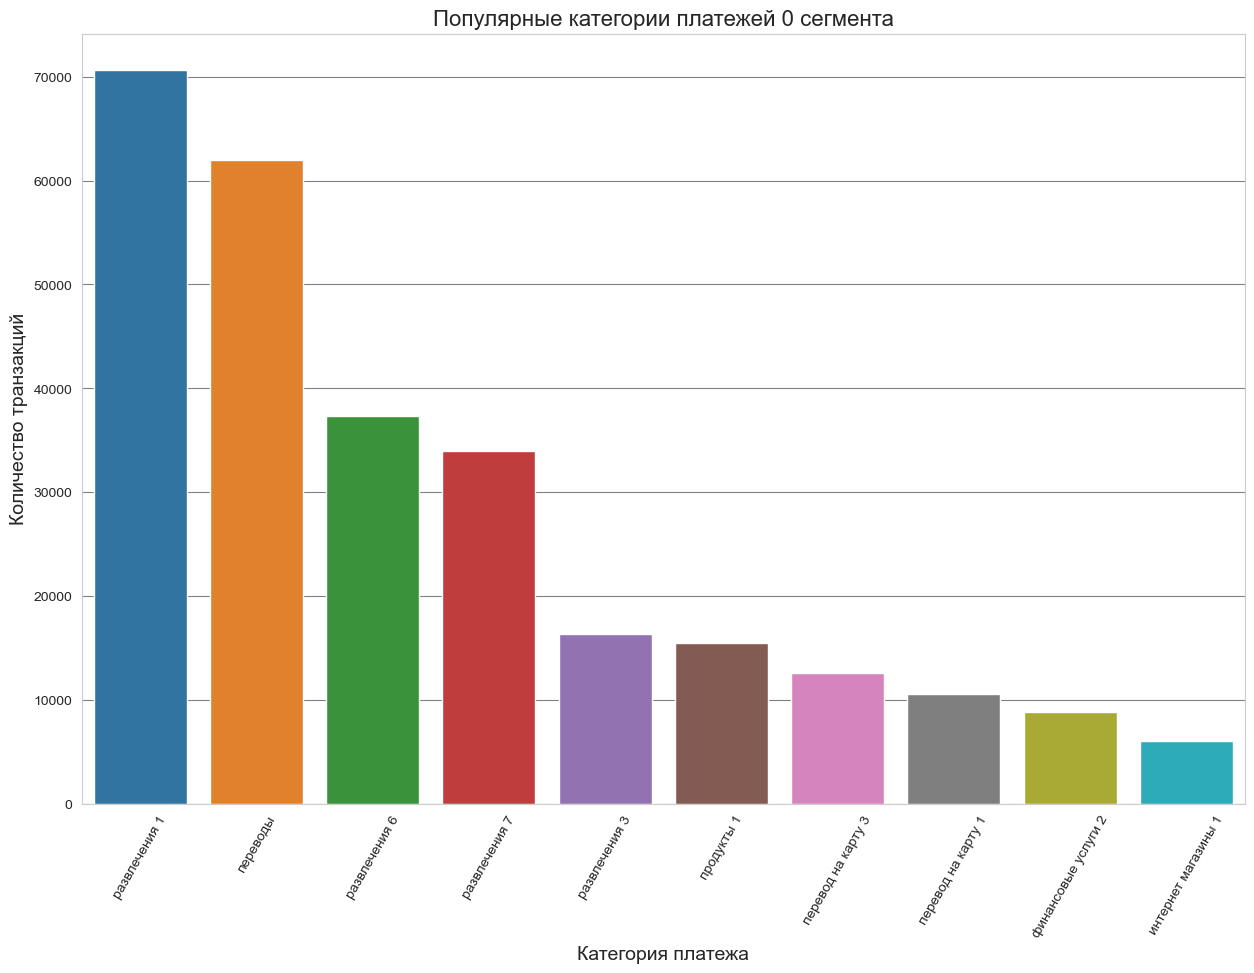

In [70]:
# Просмотр топа по категории платежей для 1 сегмента
top_cat_0 = segment_0.cat.value_counts().to_frame() \
                      .reset_index().head(10) \
                      .rename(columns={'index':'cat', 'cat':'cat_count'})

plt.figure(figsize=(15,10))
plt.grid(color='grey')
plt.xticks(rotation=60)
sns.barplot(data=top_cat_0, x='cat', y='cat_count')

plt.title('Популярные категории платежей 0 сегмента', size=16)
plt.xlabel('Категория платежа', size=14)
plt.ylabel('Количество транзакций', size=14)
plt.savefig("Категории_0_сегмент.svg")

In [71]:
segment_0.sex.value_counts(normalize=True)

0.0    0.983618
1.0    0.016382
Name: sex, dtype: float64

## Retention rate

In [72]:
# Переводим в DateTime для удобства дальнейшей работы
segment_0['txn_minute'] = pd.to_datetime(segment_0.txn_minute)

C:\Users\Рома\AppData\Local\Temp\ipykernel_7064\2202197548.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_0['txn_minute'] = pd.to_datetime(segment_0.txn_minute)


In [73]:
segment_0['month'] = segment_0['txn_minute'].dt.to_period("M")
segment_0['day'] = segment_0['txn_minute'].dt.to_period("D")

C:\Users\Рома\AppData\Local\Temp\ipykernel_7064\168789830.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_0['month'] = segment_0['txn_minute'].dt.to_period("M")
C:\Users\Рома\AppData\Local\Temp\ipykernel_7064\168789830.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_0['day'] = segment_0['txn_minute'].dt.to_period("D")


In [74]:
rr_segment_0 = segment_0.groupby('day', as_index=False) \
    .agg({'qw' : 'nunique'}) \
    .sort_values('day')

In [75]:
rr_segment_0['number_month'] = rr_segment_0['day'].dt.month

In [76]:
day_max_segment_0 = rr_segment_0.groupby(['number_month'], as_index=False).agg({'day' : 'max'}).rename(columns={'day' : 'day_max'})
day_min_segment_0 = rr_segment_0.groupby(['number_month'], as_index=False).agg({'day' : 'min'}).rename(columns={'day' : 'day_min'})

In [77]:
min_max_segment_0 = day_max_segment_0.merge(day_min_segment_0, how='inner', on='number_month')

In [78]:
to_join_max_segment_0 = rr_segment_0.rename(columns={'day' : 'day_max', 'qw' : 'max_qw'})

In [79]:
min_max_qw_segment_0 = min_max_segment_0.merge(to_join_max_segment_0, how='inner', on='day_max')

In [80]:
to_join_min_segment_0 = rr_segment_0.rename(columns={'day' : 'day_min', 'qw' : 'min_qw'})

In [81]:
min_qw_max_qw_segment_0 = min_max_qw_segment_0.merge(to_join_min_segment_0, how='inner', on='day_min')

In [82]:
RR_segment_0 = ((min_qw_max_qw_segment_0.max_qw / min_qw_max_qw_segment_0.min_qw) * 100).round(2)

In [83]:
RR_df_segment_0 = RR_segment_0.to_frame().reset_index().rename(columns={'index' : 'month', 0 : 'RR'})

In [850]:
min_qw_max_qw_segment_0.head()

,number_month_x,day_max,day_min,max_qw,number_month_y,min_qw,number_month
0,1,2022-01-24,2022-01-17,2455,1,2375,1
1,3,2022-03-28,2022-03-14,1876,3,2197,3
2,4,2022-04-25,2022-04-04,1815,4,1746,4
3,5,2022-05-23,2022-05-09,1993,5,1830,5
4,6,2022-06-30,2022-06-13,1961,6,1956,6


## Churn rate

In [85]:
churn_rate_segment_0 = (min_qw_max_qw_segment_0.min_qw - min_qw_max_qw_segment_0.max_qw) / min_qw_max_qw_segment_0.min_qw * 100

In [86]:
churn_rate_segment_0_df = churn_rate_segment_0.to_frame().reset_index().rename(columns={'index' : 'month', 0 : 'CR'})

In [87]:
churn_rate_segment_0_df.head()

,month,CR
0,0,-3.368421
1,1,14.610833
2,2,-3.951890
3,3,-8.907104
4,4,-0.255624


## revenue, уникальные юзеры, средний чек, количество транзакций

In [88]:
revenue_by_month_segment_0 = segment_0.groupby('month', as_index=False) \
    .agg({'amount' : 'sum'}) \
    .rename(columns={'amount' : 'revenue'})

In [89]:
uniq_month_segment_0 = segment_0.groupby('month', as_index=False) \
    .agg({'qw' : 'nunique'})

In [90]:
avg_check_by_month_segment_0 = segment_0.groupby('month', as_index=False) \
    .agg({'amount' : 'mean'}) \
    .rename(columns={'amount' : 'mean_avg'})

In [91]:
count_tranc_0 = segment_0.groupby('month', as_index=False) \
    .agg({'txn_id' : 'count'}) \
    .rename(columns={'txn_id' : 'tranc_count'})

## Частота транзакций

- Количество транзакций, совершенных пользователем за определенный месяц

In [92]:
transaction_frequency = segment_0.groupby('month', as_index=False) \
    .agg({'txn_id' : 'count'}) \
    .rename(columns={'txn_id' : 'transaction_count'})

transaction_frequency['number_month'] = transaction_frequency['month'].dt.month

transaction_frequency = transaction_frequency[transaction_frequency['month'] != '2022-08']

transaction_frequency.sort_values('transaction_count', ascending=False)

,month,transaction_count,number_month
5,2022-07,59487,7
4,2022-06,41928,6
1,2022-03,33924,3
9,2022-11,33253,11
3,2022-05,32412,5
2,2022-04,31146,4
8,2022-10,31047,10
0,2022-01,19828,1
7,2022-09,15581,9
10,2022-12,11878,12


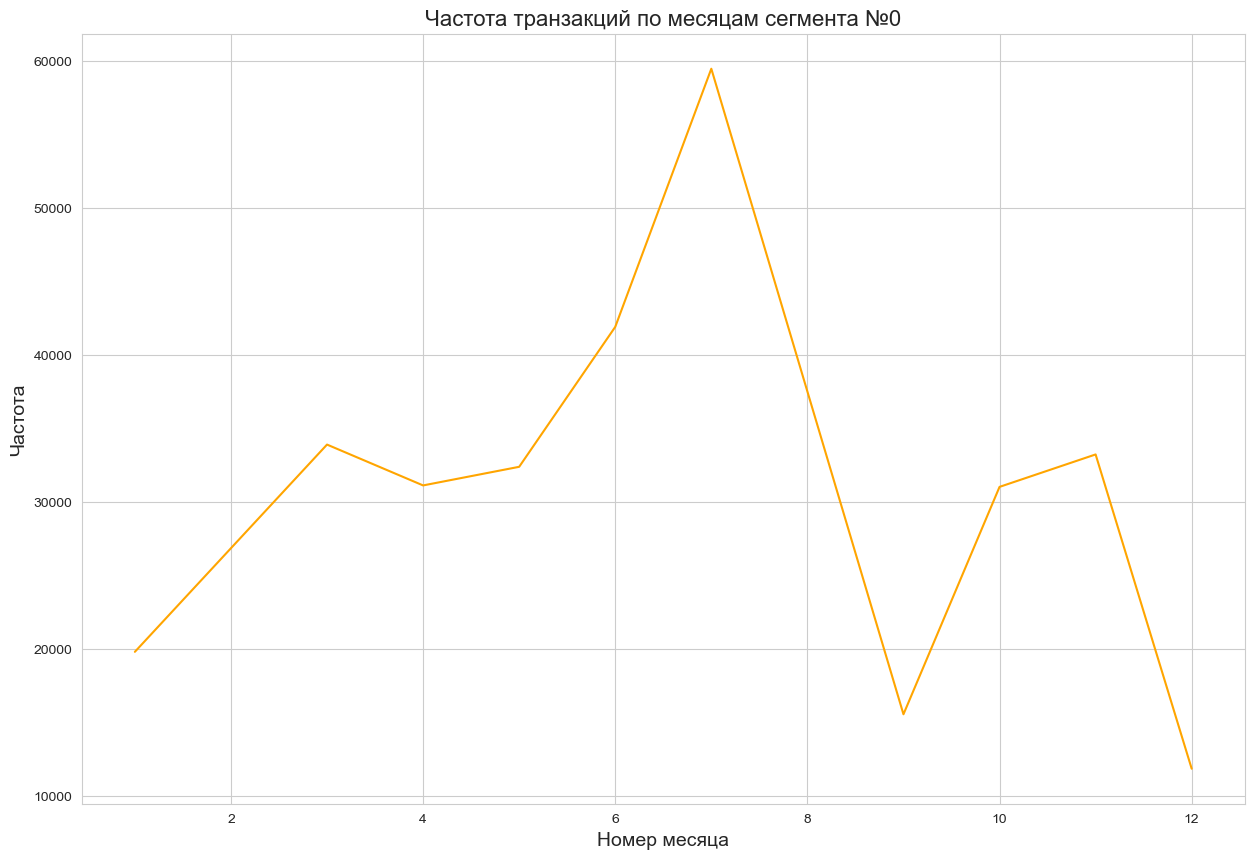

In [93]:
plt.figure(figsize=(15,10))

sns.lineplot(data=transaction_frequency, x='number_month', y='transaction_count', color = "orange")

plt.title('Частота транзакций по месяцам сегмента №0', size=16)
plt.xlabel('Номер месяца', size=14)
plt.ylabel('Частота', size=14)
plt.savefig("Частота_транзакций_0.svg")

## Средний размер транзакции

- Средняя сумма платежа, совершаемого пользователем за одну транзакцию

In [1098]:
average_transaction_size = segment_0["amount"].mean()

round(average_transaction_size, 2)

2750.49

## Предпочтительный продукт для платежей

In [1118]:
preferred_payment_product = segment_0.groupby('product', as_index=False) \
    .agg({'qw' : 'nunique'}) \
    .rename(columns={'qw' : 'count_uniq_id'})

preferred_payment_product

# Предпочительный продукт QW, но пользователи также используют виртуальную и пластиковую карту

,product,count_uniq_id
0,QW,154440
1,Виртуальная карта,13539
2,Пластиковая карта,6286


In [1119]:
preferred_payment_product.count_uniq_id.pct_change()

0         NaN
1   -0.912335
2   -0.535712
Name: count_uniq_id, dtype: float64

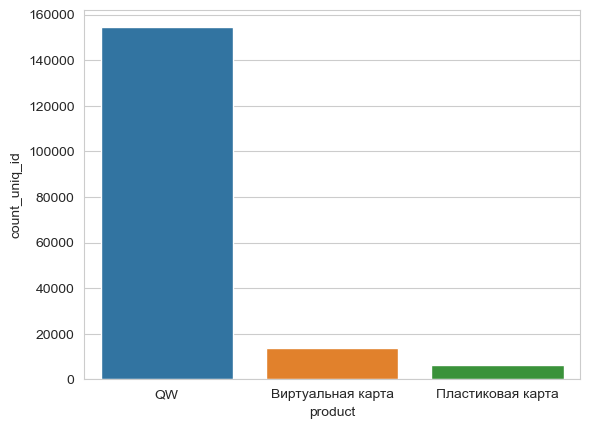

In [1120]:
sns.barplot(data=preferred_payment_product, x="product", y="count_uniq_id")
plt.savefig("preferred_payment_product_0.svg")

## Предпочтительная категория платежей

In [1157]:
preferred_payment_category  = segment_0.groupby('cat', as_index=False) \
    .agg({'qw' : 'nunique'}) \
    .sort_values('qw', ascending=False)

preferred_payment_category.head()

,cat,qw
22,переводы,39066
27,развлечения 1,31549
32,развлечения 6,26844
33,развлечения 7,17155
29,развлечения 3,10243


In [1158]:
clear_df = [re.sub(r"\d+", "", x, flags=re.UNICODE).rstrip() for x in preferred_payment_category.cat]

In [1159]:
preferred_payment_category['cat'] = clear_df

In [1160]:
clear_pref_cat = preferred_payment_category.groupby('cat', as_index=False) \
    .agg({'qw' : 'sum'}) \
    .sort_values('qw', ascending=False) \
    .rename(columns={'qw' : 'count_id'})

clear_pref_cat.head()

# Юзеры чаще используют категорию развлечений и переводов

,cat,count_id
23,развлечения,92961
19,переводы,39066
18,перевод на карту,21572
21,продукты,12284
37,финансовые услуги,8757


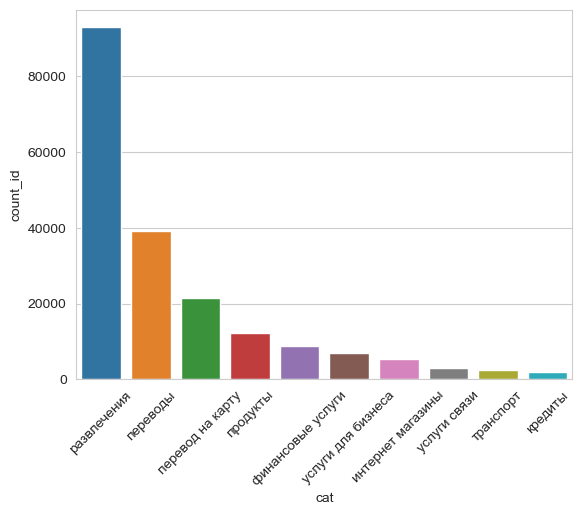

In [1139]:
sns.barplot(data=clear_pref_cat.head(10), x="cat", y="count_id")

plt.xticks(rotation=45)
plt.savefig("clear_pref_cat_0.svg")

## Общая сумма платежей по юзерам

In [102]:
total_sum = segment_0.groupby('qw', as_index=False) \
    .agg({'amount' : 'sum'}) \
    .sort_values('amount', ascending=False)

total_sum.head()

,qw,amount
108648,3046069,1.142446e+06
53643,1424272,1.118950e+06
89204,2466769,9.564272e+05
89206,2466772,9.395353e+05
149028,4198929,9.194403e+05


## Общая сумма комиссий, на которых киви заработал (+)

In [103]:
plus_fee = segment_0.query('total_fee > 0')

In [104]:
plus_fee['number_month'] = plus_fee['month'].dt.month

C:\Users\Рома\AppData\Local\Temp\ipykernel_7064\1870918321.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plus_fee['number_month'] = plus_fee['month'].dt.month


In [105]:
plus_total_fee = plus_fee.groupby('number_month', as_index=False) \
    .agg({'total_fee' : 'sum'}) \
    .sort_values('total_fee', ascending=False)

plus_total_fee

,number_month,total_fee
5,7,1.857136e+06
4,6,1.292066e+06
9,11,1.246175e+06
8,10,1.100474e+06
1,3,1.006747e+06
3,5,9.679212e+05
2,4,9.234774e+05
6,8,5.772814e+05
7,9,5.620650e+05
0,1,5.521382e+05


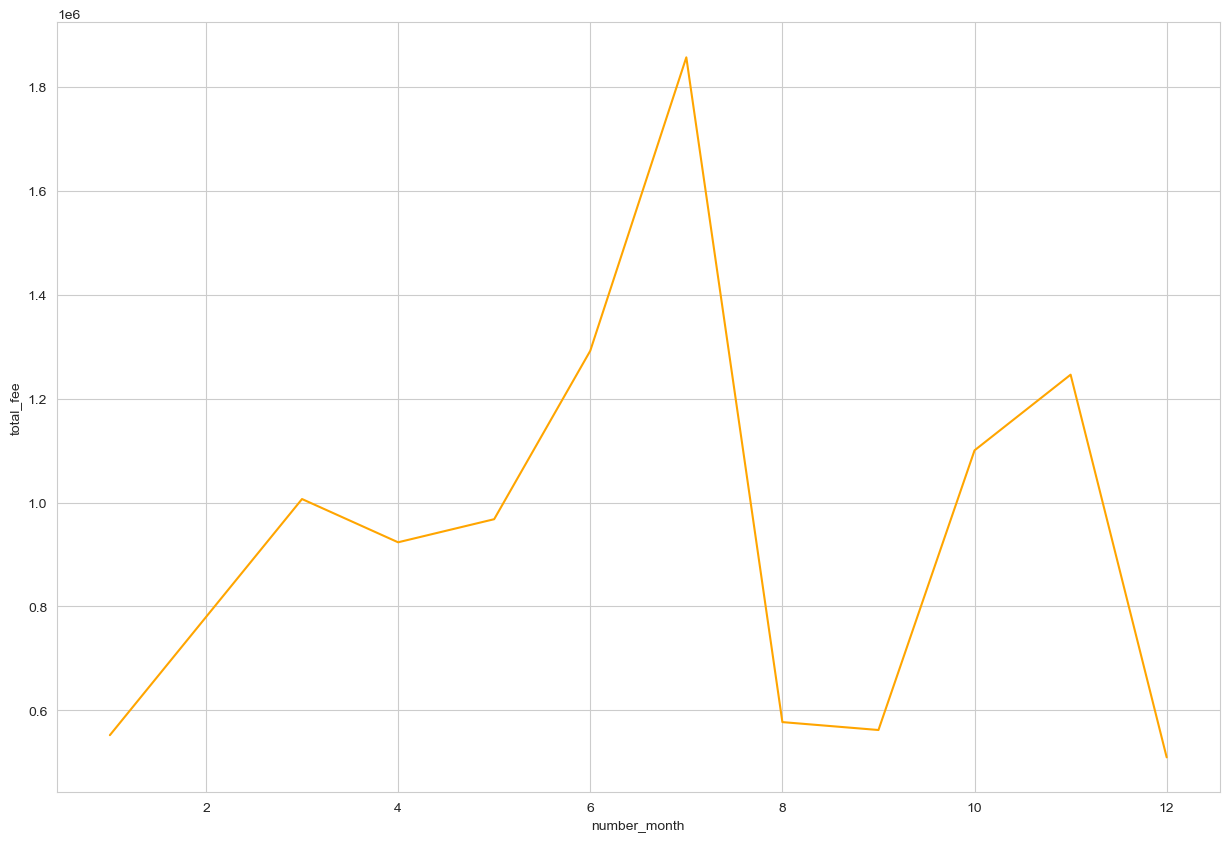

In [106]:
plt.figure(figsize=(15,10))

sns.lineplot(data=plus_total_fee, x='number_month', y='total_fee', color = "orange")
plt.savefig("plus_total_fee_0.svg")

## Общая сумма комиссий, на которых киви потерял (-)

In [107]:
minus_fee = segment_0.query('total_fee < 0')

minus_fee['number_month'] = minus_fee['month'].dt.month

C:\Users\Рома\AppData\Local\Temp\ipykernel_7064\2284660632.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  minus_fee['number_month'] = minus_fee['month'].dt.month


In [108]:
mines_total_fee = minus_fee.groupby('number_month', as_index=False) \
    .agg({'total_fee' : 'sum'}) \
    .sort_values('total_fee', ascending=False)

mines_total_fee.tail()

,number_month,total_fee
2,4,-16355.146618
1,3,-16363.964324
3,5,-16881.193354
4,6,-20422.976234
5,7,-29890.899177


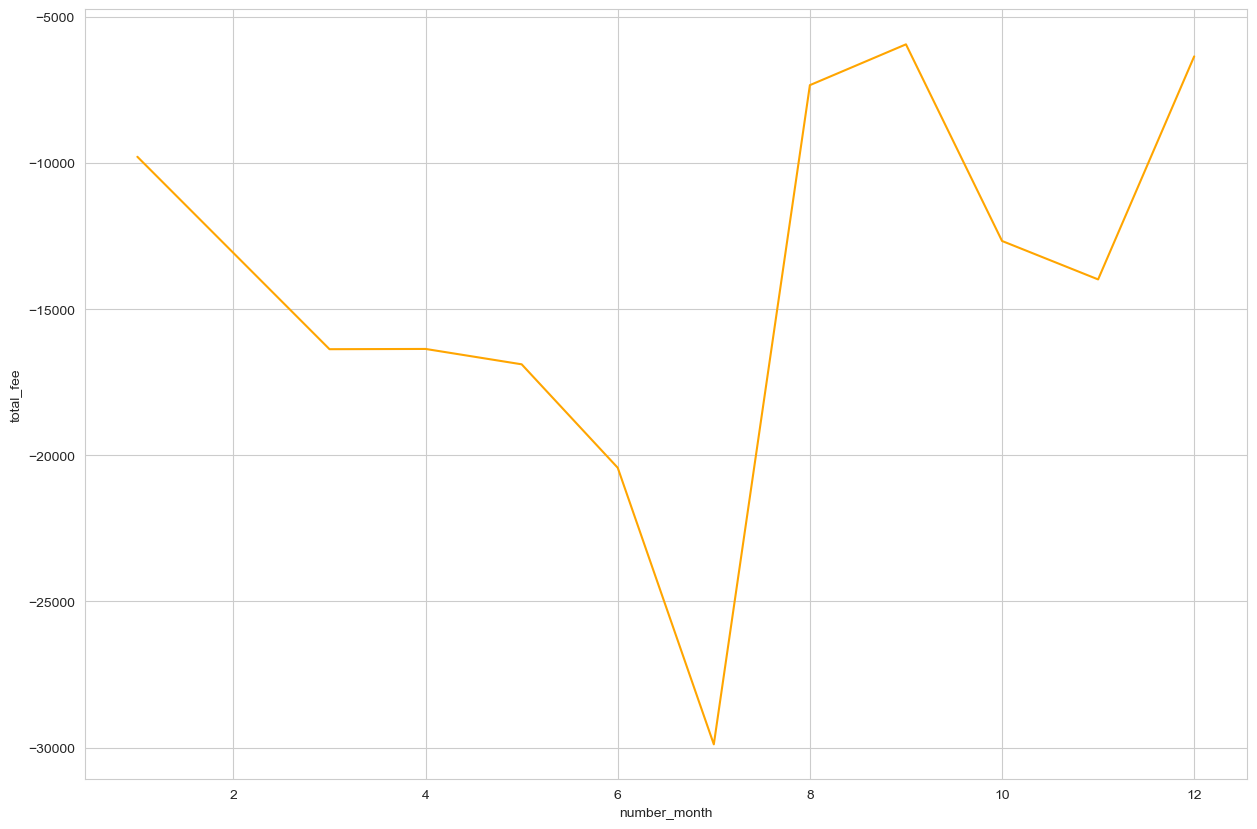

In [109]:
plt.figure(figsize=(15,10))

sns.lineplot(data=mines_total_fee, x='number_month', y='total_fee', color = "orange")

plt.savefig("mines_total_fee_0.svg")

## Временной интервал между транзакциями

- Время, прошедшее между двумя последовательными транзакциями пользователя.

In [110]:
segment_diff = segment_0.sort_values(by=["qw", "txn_minute"])

In [1055]:
segment_diff["time_interval"] = segment_diff.groupby("qw")["txn_minute"].diff()

segment_diff[["qw", "txn_minute", "time_interval"]].tail()

,qw,txn_minute,time_interval
110951,4631137,2022-03-14 22:59:00,NaT
299168,4631143,2022-08-23 14:45:00,NaT
985950,4631143,2022-08-25 11:48:00,1 days 21:03:00
671655,4631146,2022-07-16 14:54:00,NaT
584555,4631149,2022-11-14 07:55:00,NaT


In [113]:
segment_diff[segment_diff.time_interval > '0 days 00:00:00'].sort_values('time_interval').head()

,txn_id,txn_minute,qw,txn_type,product,cat,amount,client_fee,payout_fee,interchange_fee,paysys_fee,payin_fee,cluster,sex,nationality,year_birth,total_fee,month,day,time_interval
449460,106053266,2022-01-24 16:32:00,2979394,payout,QW,переводы,226.8,0.00,-0.0,0.000,-0.000,-0.0,0,0.0,0.0,1988.0,0.00,2022-01,2022-01-24,0 days 00:01:00
894759,120728802,2022-03-21 09:08:00,692936,payout,QW,переводы,700.0,0.00,-0.0,0.000,-0.000,-0.0,0,0.0,0.0,1988.0,0.00,2022-03,2022-03-21,0 days 00:01:00
402578,133440223,2022-05-19 14:51:00,4112411,payout,Виртуальная карта,продукты 1,483.0,0.00,-0.0,7.245,-3.415,-0.0,0,0.0,0.0,1988.0,3.83,2022-05,2022-05-19,0 days 00:01:00
170685,104618880,2022-01-18 23:51:00,3431462,payout,QW,переводы,700.0,0.00,-0.0,0.000,-0.000,-0.0,0,0.0,0.0,1988.0,0.00,2022-01,2022-01-18,0 days 00:01:00
184755,168328073,2022-10-14 12:48:00,1321991,payout,QW,развлечения 3,262.5,5.25,-5.0,0.000,-0.000,-0.0,0,0.0,0.0,1988.0,0.25,2022-10,2022-10-14,0 days 00:01:00


In [1065]:
all_users_df = segment_diff.groupby('month', as_index=False) \
    .agg({'time_interval' : 'mean'})

all_users_df['number_month'] = all_users_df['month'].dt.month

In [1066]:
days_interval = [str(x).split(' ')[0] for x in all_users_df.time_interval]

In [1067]:
all_users_df['days_interval'] = days_interval

In [1068]:
all_users_df = all_users_df.sort_values('days_interval', ascending=False)

In [1074]:
all_users_df.sort_values('month', ascending=True).head()

,month,time_interval,number_month,days_interval
0,2022-01,1 days 15:01:28.193447737,1,1
1,2022-03,15 days 02:24:52.293268329,3,15
2,2022-04,16 days 03:27:00.190521552,4,16
3,2022-05,21 days 17:21:54.860259950,5,21
4,2022-06,26 days 21:12:15.271418286,6,26


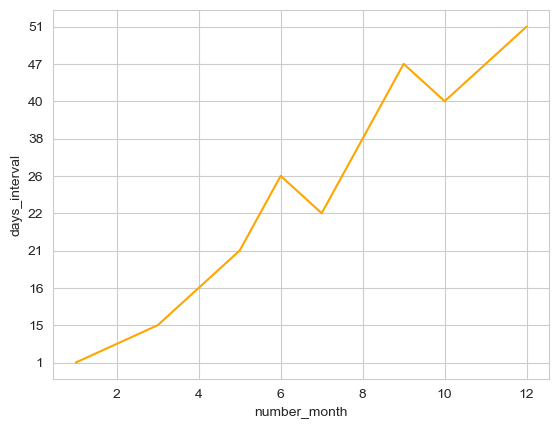

In [1061]:
sns.lineplot(data=all_users_df, x='number_month', y='days_interval', color = "orange")

plt.savefig("all_users_df_0.svg")

## Типы транзакций

- Какие типы транзакций пользователь обычно совершает

In [1165]:
transaction_types = segment_0.groupby('txn_type', as_index=False) \
    .agg({'qw' : 'nunique'}) \
    .rename(columns={'qw' : 'count_id'})

transaction_types.head()

# Тип операции нашего 0 сегмента только снятие, что объсняет нашу выручку, поскольку комиссия за снятие обычно выше

,txn_type,count_id
0,payout,168413


## Приблизительная продолжительность сессии юзера

- Предположим, что все транзакции пользователя, совершенные в течение 30 минут после предыдущей транзакции, являются частью одной сессии. Таким образом, можно объединить все транзакции, совершенные в течение 30 минут в одну сессию и вычислить продолжительность этой сессии

In [120]:
approximate_session = segment_diff.copy()

# заполнение пропущенных значений в столбце "time_interval" значением 0 (для первой транзакции пользователя)
approximate_session['time_interval'] = approximate_session['time_interval'].fillna(pd.Timedelta(seconds=0))

In [134]:
# определение сессий (предполагаем, что все транзакции, совершенные в течение 30 минут после предыдущей транзакции,
# являются частью одной сессии)
approximate_session['session'] = (approximate_session['time_interval'] > pd.Timedelta(minutes=30)).cumsum()

# расчет продолжительности каждой сессии
approximate_session['approximate'] = approximate_session.groupby(['qw', 'session'])['time_interval'].cumsum()

# расчет средней продолжительности сессии
mean_session_duration = approximate_session['approximate'].mean()

print('Средняя продолжительность сессии 0 сегмента:', mean_session_duration)

Средняя продолжительность сессии 0 сегмента: 14 days 22:29:55.664313055


## Пиковый день / время

In [122]:
pic_day_time = segment_0.copy()

In [123]:
pic_day_time['txn_minute'] = pd.to_datetime(pic_day_time['txn_minute'])

pic_day_time['day'] = pic_day_time['txn_minute'].dt.dayofweek

# Подсчет количества транзакций для каждого дня недели
transactions_by_day = pic_day_time.groupby('day').size()

# Поиск пикового дня
peak_day = transactions_by_day.idxmax()
peak_day_count = transactions_by_day.max()

print("Пиковый день:", peak_day)
print("Количество транзакций:", peak_day_count)

Пиковый день: 0
Количество транзакций: 83863


Инсайт: юзеры 0 сегмента чаще всего совершают транзакции в понедельник

## Сезонность

In [124]:
seasonality = segment_0.copy()

In [125]:
seasonality['txn_minute'] = pd.to_datetime(seasonality['txn_minute'])

seasonality["month"] = seasonality["txn_minute"].dt.month

In [126]:
transactions_per_month = seasonality.groupby(seasonality['txn_minute'].dt.strftime('%Y-%m'))['txn_id'].count()

transactions_per_month.nlargest(3)

#Топ 3 месяца по количеству транзакций

txn_minute
2022-07    59487
2022-06    41928
2022-03    33924
Name: txn_id, dtype: int64

## Частота использования продуктов и категорий

- 1 означает, что пользователь не менял продукт или категорию и пользовался ими все время
- 2 означает, что пользователь 1 раз поменял продукт или категорию
- 3 означает, что пользователь 2 раза поменял продукт или категорию
и т.д

In [127]:
# Группировка данных по ID пользователя и расчет количества уникальных значений для каждой колонки

user_counts = segment_0.groupby('qw').nunique()

In [128]:
product_freq = user_counts['product'].value_counts(normalize=True)

category_freq = user_counts['cat'].value_counts(normalize=True)

In [129]:
round(product_freq, 4)

1    0.9659
2    0.0335
3    0.0006
Name: product, dtype: float64

In [1088]:
round(category_freq, 4)

1     0.8424
2     0.1140
3     0.0260
4     0.0080
0     0.0052
5     0.0024
6     0.0011
7     0.0005
8     0.0002
9     0.0001
10    0.0001
11    0.0000
12    0.0000
18    0.0000
Name: cat, dtype: float64

## Распределение возраста пользаков без учета 1988 (искажает сильно)

In [131]:
age_users_df = segment_0.query('year_birth != 1988')

Text(0, 0.5, 'Частота')

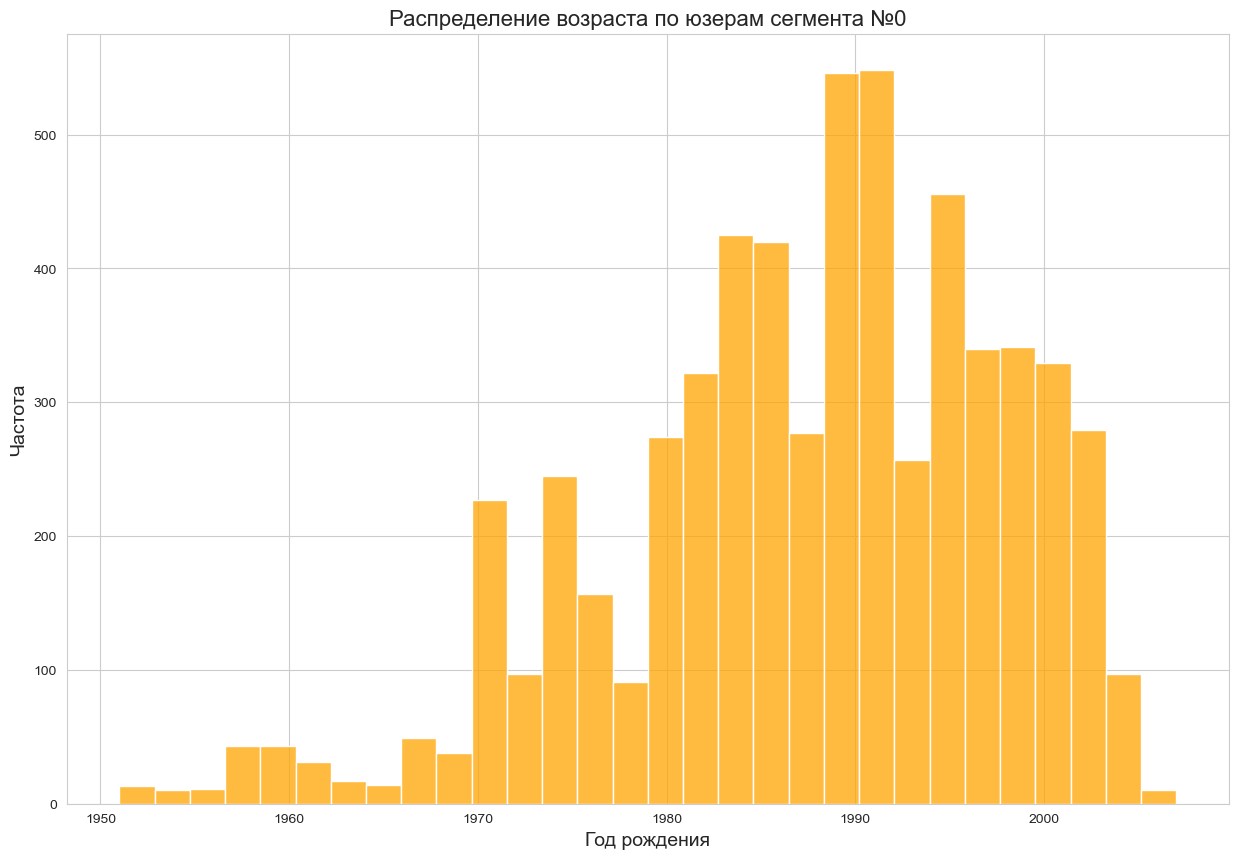

In [132]:
plt.figure(figsize=(15,10))

sns.histplot(data=age_users_df, x="year_birth", bins=30, color='orange')

plt.title('Распределение возраста по юзерам сегмента №0', size=16)
plt.xlabel('Год рождения', size=14)
plt.ylabel('Частота', size=14)

## Сегмент №1

In [534]:
segment_1 = segments.query('cluster == 1')

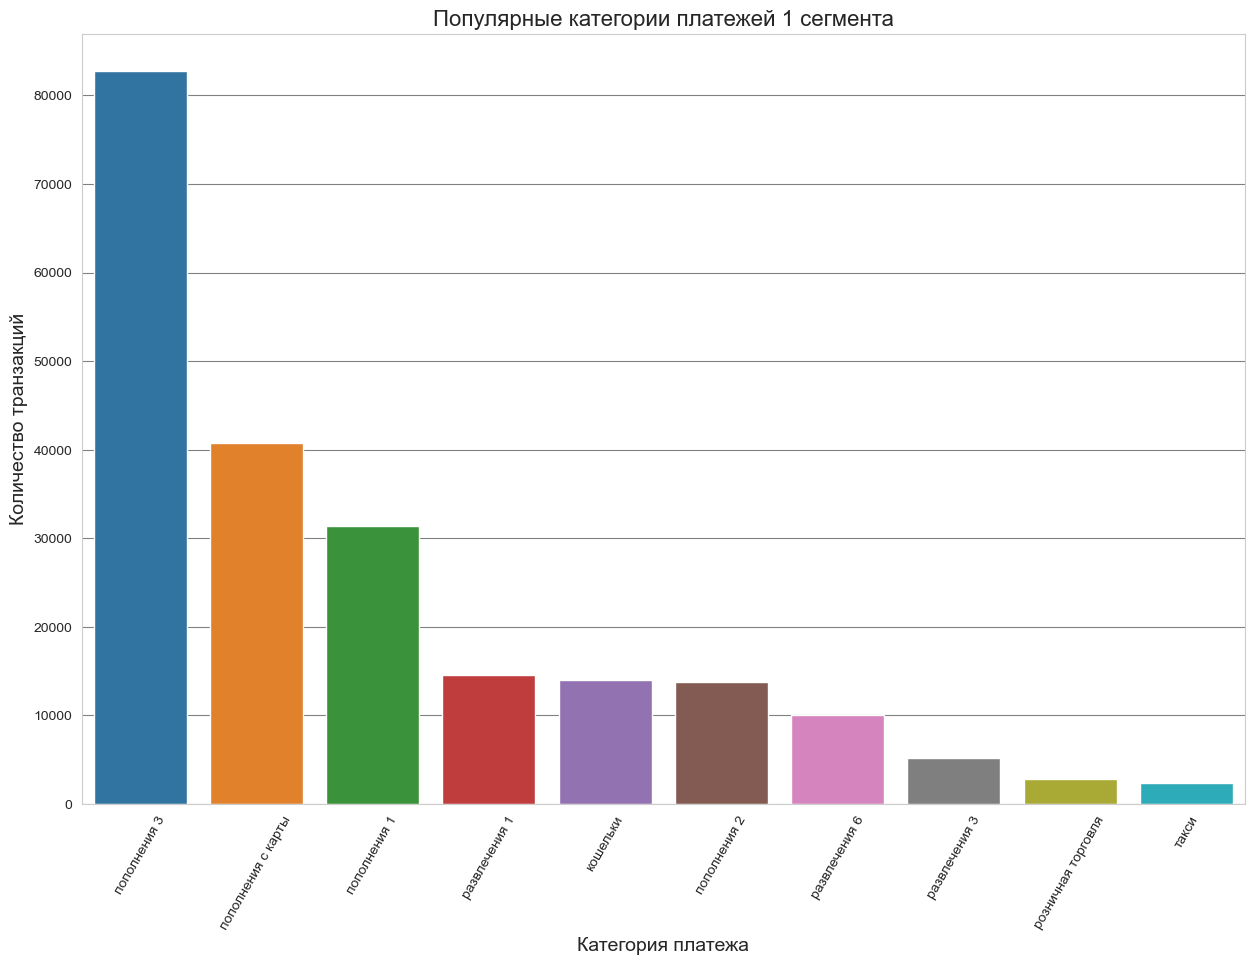

In [559]:
# Просмотр топа по категории платежей для 2 сегмента
top_cat_1 = segment_1.cat.value_counts().to_frame() \
                      .reset_index().head(10) \
                      .rename(columns={'index':'cat', 'cat':'cat_count'})

plt.figure(figsize=(15,10))
plt.grid(color='grey')
plt.xticks(rotation=60)
sns.barplot(data=top_cat_1, x='cat', y='cat_count')

plt.title('Популярные категории платежей 1 сегмента', size=16)
plt.xlabel('Категория платежа', size=14)
plt.ylabel('Количество транзакций', size=14)
plt.savefig("Категории_1_сегмент.svg")

## Retention rate

In [560]:
# Переводим в DateTime для удобства дальнейшей работы
segment_1['txn_minute'] = pd.to_datetime(segment_1.txn_minute)

C:\Users\Рома\AppData\Local\Temp\ipykernel_7064\1613545789.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_1['txn_minute'] = pd.to_datetime(segment_1.txn_minute)


In [561]:
segment_1['month'] = segment_1['txn_minute'].dt.to_period("M")
segment_1['day'] = segment_1['txn_minute'].dt.to_period("D")

C:\Users\Рома\AppData\Local\Temp\ipykernel_7064\365083922.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_1['month'] = segment_1['txn_minute'].dt.to_period("M")
C:\Users\Рома\AppData\Local\Temp\ipykernel_7064\365083922.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_1['day'] = segment_1['txn_minute'].dt.to_period("D")


In [562]:
rr_segment_1 = segment_1.groupby('day', as_index=False) \
    .agg({'qw' : 'nunique'}) \
    .sort_values('day')

In [563]:
rr_segment_1['number_month'] = rr_segment_1['day'].dt.month

In [564]:
day_max_segment_1 = rr_segment_1.groupby(['number_month'], as_index=False).agg({'day' : 'max'}).rename(columns={'day' : 'day_max'})
day_min_segment_1 = rr_segment_1.groupby(['number_month'], as_index=False).agg({'day' : 'min'}).rename(columns={'day' : 'day_min'})

In [565]:
min_max_segment_1 = day_max_segment_1.merge(day_min_segment_1, how='inner', on='number_month')

to_join_max_segment_1 = rr_segment_1.rename(columns={'day' : 'day_max', 'qw' : 'max_qw'})

min_max_qw_segment_1 = min_max_segment_1.merge(to_join_max_segment_1, how='inner', on='day_max')

to_join_min_segment_1 = rr_segment_1.rename(columns={'day' : 'day_min', 'qw' : 'min_qw'})

min_qw_max_qw_segment_1 = min_max_qw_segment_1.merge(to_join_min_segment_1, how='inner', on='day_min')

RR_segment_1 = ((min_qw_max_qw_segment_1.max_qw / min_qw_max_qw_segment_1.min_qw) * 100).round(2)

RR_df_segment_1 = RR_segment_1.to_frame().reset_index().rename(columns={'index' : 'month', 0 : 'RR'})

In [566]:
RR_df_segment_1.head()

,month,RR
0,0,107.90
1,1,89.21
2,2,104.86
3,3,110.87
4,4,112.69


In [876]:
max_time_0 = segment_0.groupby('day', as_index=False).agg({'txn_minute' : 'max'}).rename(columns={'txn_minute' : 'max_time_day'})

In [877]:
min_time_0 = segment_0.groupby('day', as_index=False).agg({'txn_minute' : 'min'}).rename(columns={'txn_minute' : 'min_time_day'})

In [878]:
join_max_time_0 = segment_0.merge(max_time_0, how='left', on='day')

In [879]:
join_max_min_time_0 = join_max_time_0.merge(min_time_0, how='left', on='day')

In [880]:
users_max_time_day_0 = join_max_min_time_0.groupby('max_time_day', as_index=False).agg({'qw' : 'nunique'})

In [881]:
users_min_time_day_0 = join_max_min_time_0.groupby('min_time_day', as_index=False).agg({'qw' : 'nunique'})

## Churn rate

In [573]:
churn_rate_segment_1 = (min_qw_max_qw_segment_1.min_qw - min_qw_max_qw_segment_1.max_qw) / min_qw_max_qw_segment_1.min_qw * 100

churn_rate_segment_1_df = churn_rate_segment_1.to_frame().reset_index().rename(columns={'index' : 'month', 0 : 'CR'})

In [574]:
churn_rate_segment_1_df.head()

,month,CR
0,0,-7.902382
1,1,10.789632
2,2,-4.858934
3,3,-10.872894
4,4,-12.692308


## revenue, уникальные юзеры, средний чек, количество транзакций

In [575]:
revenue_by_month_segment_1 = segment_1.groupby('month', as_index=False) \
    .agg({'amount' : 'sum'}) \
    .rename(columns={'amount' : 'revenue'})

In [576]:
uniq_month_segment_1 = segment_1.groupby('month', as_index=False) \
    .agg({'qw' : 'nunique'})

In [577]:
avg_check_by_month_segment_1 = segment_1.groupby('month', as_index=False) \
    .agg({'amount' : 'mean'}) \
    .rename(columns={'amount' : 'mean_avg'})

In [578]:
count_tranc_1 = segment_1.groupby('month', as_index=False) \
    .agg({'txn_id' : 'count'}) \
    .rename(columns={'txn_id' : 'tranc_count'})

## Частота транзакций

- Количество транзакций, совершенных пользователем за определенный месяц

In [579]:
transaction_frequency_1 = segment_1.groupby('month', as_index=False) \
    .agg({'txn_id' : 'count'}) \
    .rename(columns={'txn_id' : 'transaction_count'})

transaction_frequency_1['number_month'] = transaction_frequency_1['month'].dt.month

transaction_frequency_1.head()

,month,transaction_count,number_month
0,2022-01,14191,1
1,2022-03,24688,3
2,2022-04,22121,4
3,2022-05,22617,5
4,2022-06,27947,6


Text(0, 0.5, 'Частота')

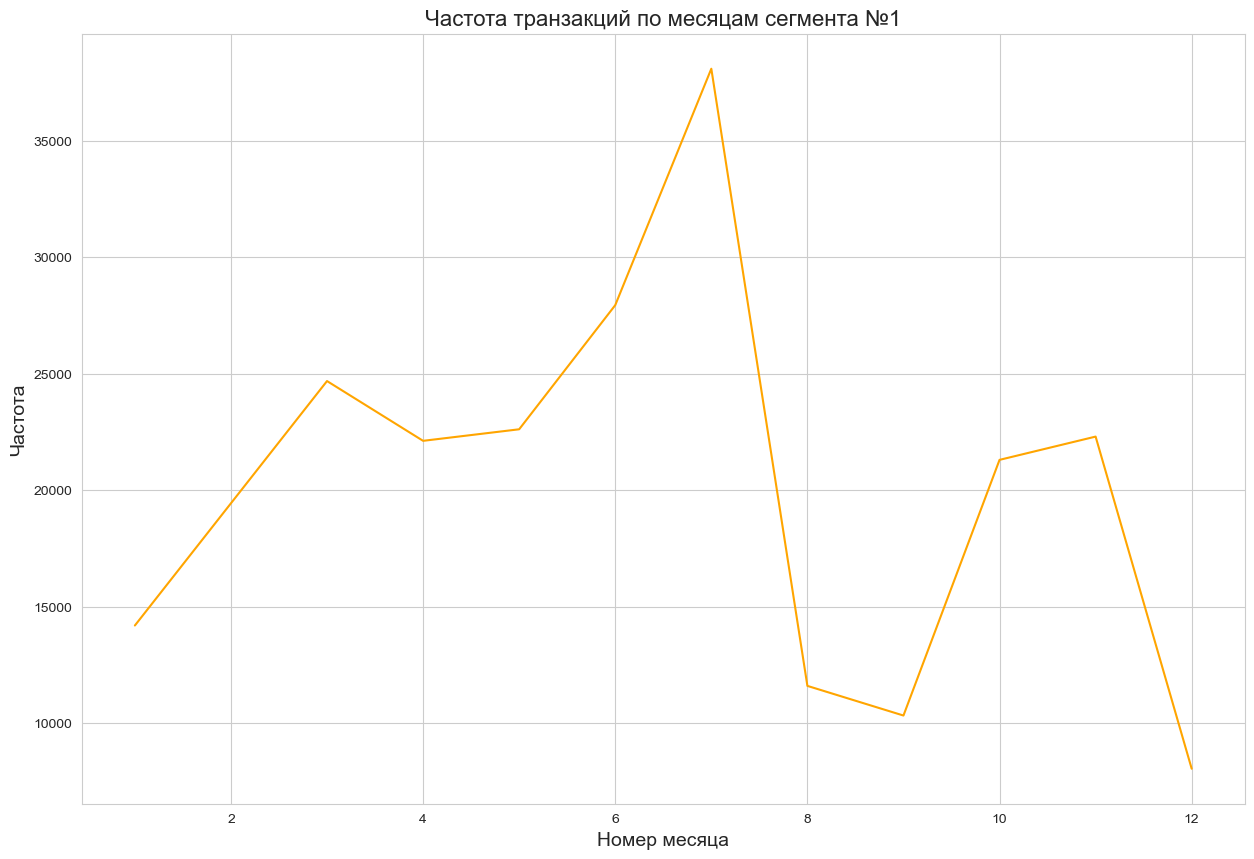

In [580]:
plt.figure(figsize=(15,10))

sns.lineplot(data=transaction_frequency_1, x='number_month', y='transaction_count', color = "orange")

plt.title('Частота транзакций по месяцам сегмента №1', size=16)
plt.xlabel('Номер месяца', size=14)
plt.ylabel('Частота', size=14)

## Средний размер транзакции

- Средняя сумма платежа, совершаемого пользователем за одну транзакцию

In [1099]:
average_transaction_size_1 = segment_1["amount"].mean()

round(average_transaction_size_1, 2)

2709.25

## Предпочительный продукт для платежей

In [1121]:
preferred_payment_product_1 = segment_1.groupby('product', as_index=False) \
    .agg({'qw' : 'nunique'}) \
    .rename(columns={'qw' : 'count_uniq_id'})

preferred_payment_product_1

# Пользователи используют только продукт QW

,product,count_uniq_id
0,QW,145014


<AxesSubplot:xlabel='product', ylabel='count_uniq_id'>

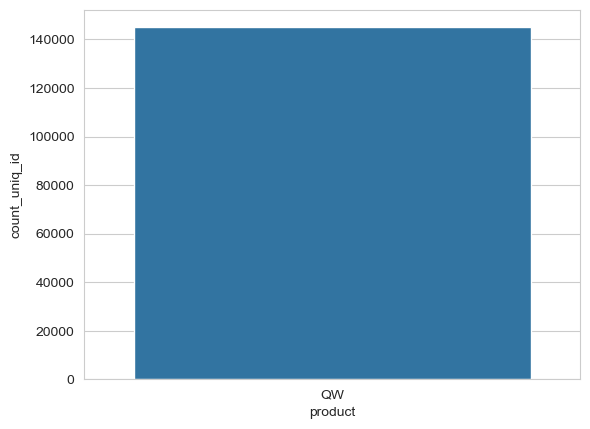

In [1122]:
sns.barplot(data=preferred_payment_product_1, x="product", y="count_uniq_id")

## Предпочтительная категория платежей

In [584]:
preferred_payment_category_1  = segment_1.groupby('cat', as_index=False) \
    .agg({'qw' : 'nunique'}) \
    .sort_values('qw', ascending=False)

preferred_payment_category_1

# Юзеры чаще используют категорию пополнений

,cat,qw
4,пополнения 3,56436
6,пополнения с карты,29119
2,пополнения 1,23456
3,пополнения 2,12148
0,кошельки,10576
7,развлечения 1,9722
10,развлечения 6,8131
8,развлечения 3,4053
11,розничная торговля,2287
13,такси,1065


In [1161]:
clear_df_1 = [re.sub(r"\d+", "", x, flags=re.UNICODE).rstrip() for x in preferred_payment_category_1.cat]

preferred_payment_category_1['cat'] = clear_df_1

clear_pref_cat_1 = preferred_payment_category_1.groupby('cat', as_index=False) \
    .agg({'qw' : 'sum'}) \
    .sort_values('qw', ascending=False) \
    .rename(columns={'qw' : 'count_id'}) \
    .head()

clear_pref_cat_1

# Юзеры чаще используют категорию развлечений и переводов

,cat,count_id
2,пополнения,92404
3,пополнения с карты,29119
4,развлечения,22825
0,кошельки,10576
5,розничная торговля,2287


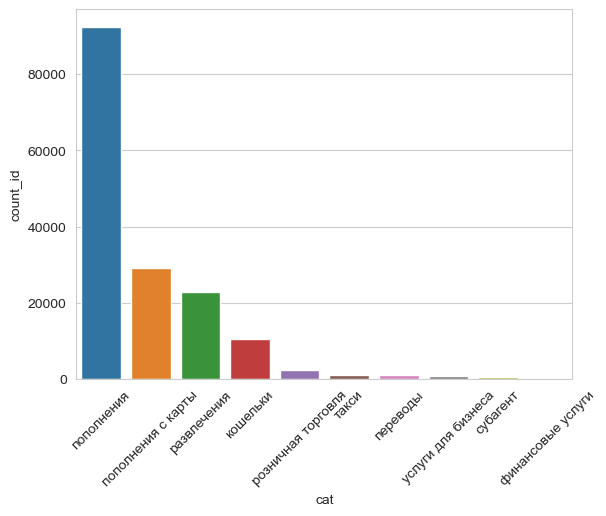

In [1141]:
sns.barplot(data=clear_pref_cat_1.head(10), x="cat", y="count_id")

plt.xticks(rotation=45)

plt.savefig('clear_pref_cat_1.svg')

## Общая сумма платежей по юзерам

In [587]:
total_sum_1 = segment_1.groupby('qw', as_index=False) \
    .agg({'amount' : 'sum'}) \
    .sort_values('amount', ascending=False)

total_sum_1.head()

,qw,amount
28049,836825,887473.3000
114408,3734812,882148.7500
68251,2217019,847685.9475
63016,2030789,761737.8300
125502,4067891,636074.0575


## Общая сумма комиссий, на которых киви заработал (+)

In [588]:
plus_fee_1 = segment_1.query('total_fee > 0')

plus_fee_1['number_month'] = plus_fee_1['month'].dt.month

In [589]:
plus_total_fee_1 = plus_fee_1.groupby('number_month', as_index=False) \
    .agg({'total_fee' : 'sum'}) \
    .sort_values('total_fee', ascending=False)

plus_total_fee_1.head()

# Как видим, мы не заработали на пользователях сегмента №1

,number_month,total_fee


<AxesSubplot:>

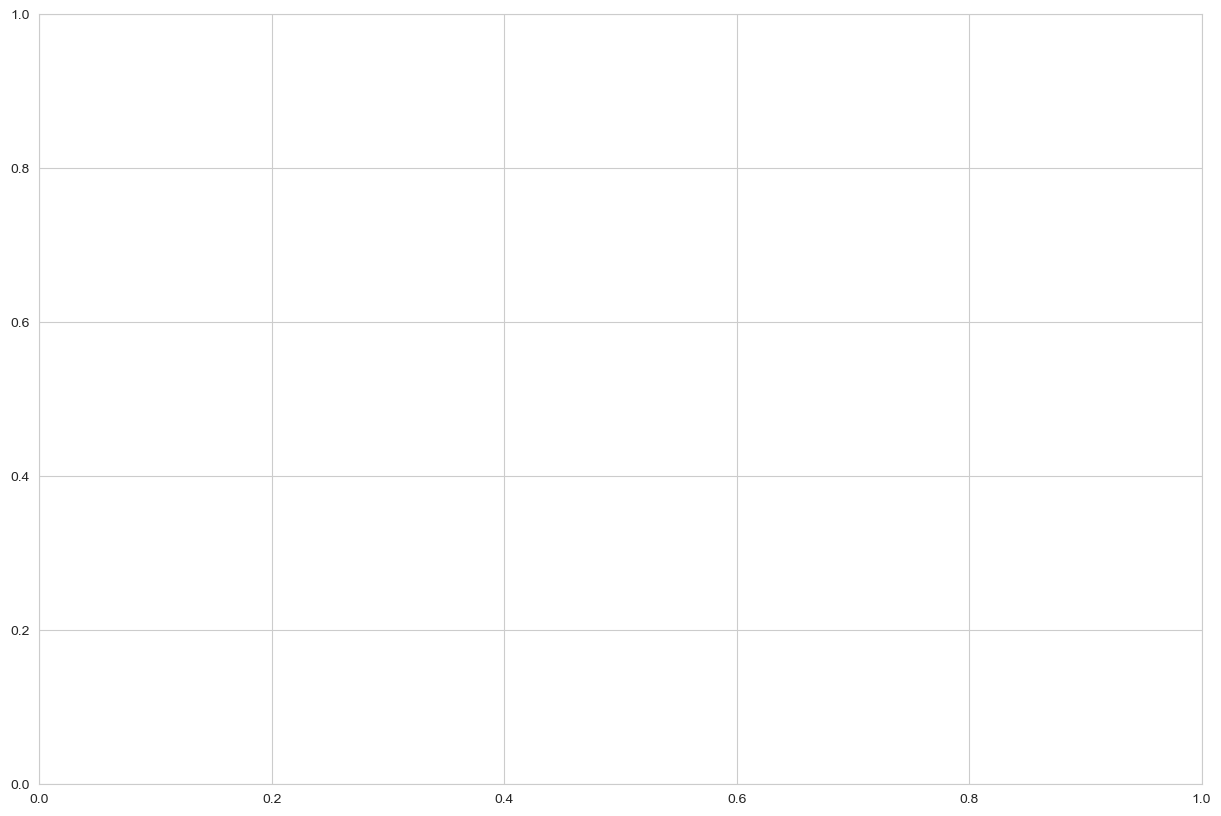

In [590]:
plt.figure(figsize=(15,10))

sns.lineplot(data=plus_total_fee_1, x='number_month', y='total_fee', color = "orange")

## Общая сумма комиссий, на которых киви потерял (-)

In [591]:
minus_fee_1 = segment_1.query('total_fee < 0')

minus_fee_1['number_month'] = minus_fee_1['month'].dt.month

C:\Users\Рома\AppData\Local\Temp\ipykernel_7064\4153687486.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  minus_fee_1['number_month'] = minus_fee_1['month'].dt.month


In [592]:
mines_total_fee_1 = minus_fee_1.groupby('number_month', as_index=False) \
    .agg({'total_fee' : 'sum'}) \
    .sort_values('total_fee', ascending=False)

mines_total_fee_1.tail()

,number_month,total_fee
1,3,-357522.637178
8,10,-379134.390393
9,11,-407345.940022
4,6,-431587.637012
5,7,-625474.801026


<AxesSubplot:xlabel='number_month', ylabel='total_fee'>

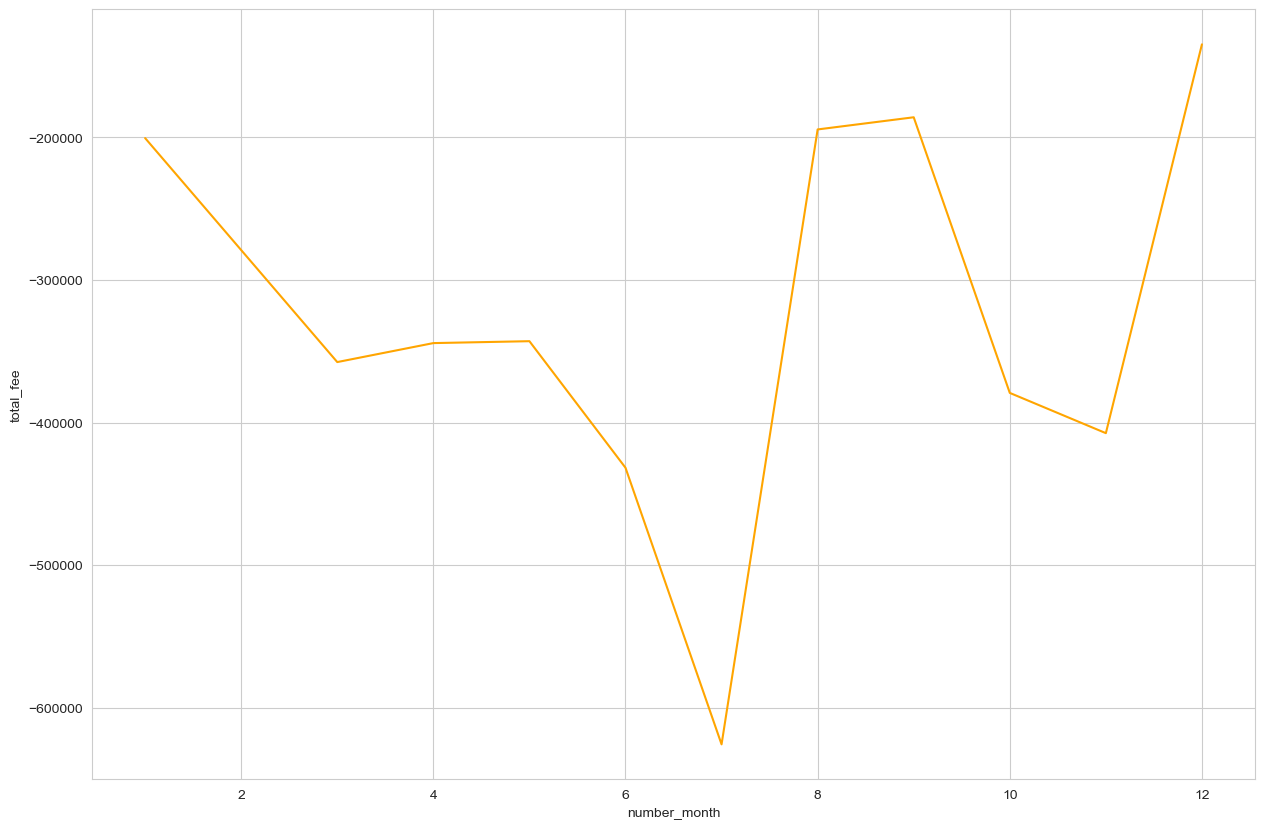

In [593]:
plt.figure(figsize=(15,10))

sns.lineplot(data=mines_total_fee_1, x='number_month', y='total_fee', color = "orange")

## Временной интервал между транзакциями

- Время, прошедшее между двумя последовательными транзакциями пользователя.

In [594]:
segment_diff_1 = segment_1.sort_values(by=["qw", "txn_minute"])

In [595]:
segment_diff_1["time_interval"] = segment_diff_1.groupby("qw")["txn_minute"].diff()

segment_diff_1[["qw", "txn_minute", "time_interval"]].tail()

,qw,txn_minute,time_interval
530813,4631143,2022-05-18 08:54:00,NaT
663083,4631143,2022-06-25 22:39:00,38 days 13:45:00
159537,4631143,2022-07-27 04:18:00,31 days 05:39:00
707540,4631143,2022-08-01 09:03:00,5 days 04:45:00
265310,4631149,2022-12-13 06:35:00,NaT


In [596]:
segment_diff_1[segment_diff_1.time_interval > '0 days 00:00:00'].sort_values('time_interval').head()

,txn_id,txn_minute,qw,txn_type,product,cat,amount,client_fee,payout_fee,interchange_fee,...,payin_fee,cluster,sex,nationality,year_birth,total_fee,month,number_month,day,time_interval
882128,120634106,2022-03-20 19:34:00,4044459,payin,QW,переводы,1312.5000,0.0,-0.0,0.0,...,-1.31250,1,0.0,0.0,1988.0,-1.31250,2022-03,3,2022-03-20,0 days 00:01:00
483184,141131858,2022-06-22 10:57:00,4345180,payin,QW,такси,277.4625,0.0,-0.0,0.0,...,-2.21970,1,0.0,0.0,1988.0,-2.21970,2022-06,6,2022-06-22,0 days 00:01:00
382552,175043146,2022-11-10 12:54:00,936144,payin,QW,пополнения 3,78.7500,0.0,-0.0,0.0,...,-0.07875,1,0.0,0.0,1988.0,-0.07875,2022-11,11,2022-11-10,0 days 00:01:00
601478,163282179,2022-09-23 12:27:00,4354030,payin,QW,пополнения 3,14000.0000,0.0,-0.0,0.0,...,-14.00000,1,0.0,0.0,1988.0,-14.00000,2022-09,9,2022-09-23,0 days 00:01:00
736678,174280548,2022-11-07 09:40:00,713831,payin,QW,пополнения 3,17500.0000,0.0,-0.0,0.0,...,-17.50000,1,0.0,0.0,1988.0,-17.50000,2022-11,11,2022-11-07,0 days 00:01:00


In [1081]:
all_users_df_1 = segment_diff_1.groupby('month', as_index=False) \
    .agg({'time_interval' : 'mean'})

all_users_df_1['number_month'] = all_users_df_1['month'].dt.month

days_interval_2 = [str(x).split(' ')[0] for x in all_users_df_1.time_interval]

all_users_df_1['days_interval_2'] = days_interval_2

In [1117]:
all_users_df_1.sort_values('month').head()

,month,time_interval,number_month,days_interval_2
0,2022-01,1 days 19:37:27.309417040,1,1
1,2022-03,17 days 03:17:41.557276804,3,17
2,2022-04,20 days 09:46:19.187242798,4,20
3,2022-05,27 days 14:49:40.481118881,5,27
4,2022-06,35 days 00:43:25.336524080,6,35


<AxesSubplot:xlabel='number_month', ylabel='days_interval_2'>

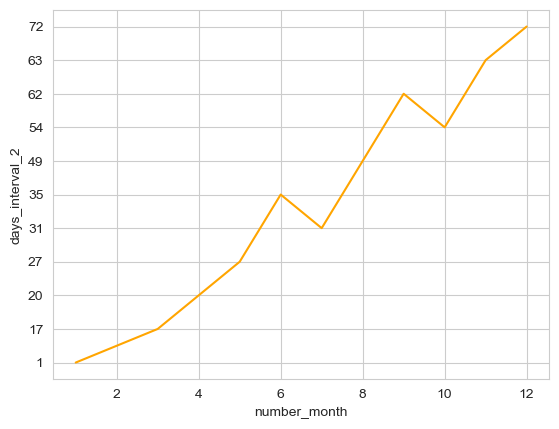

In [1083]:
all_users_df_1 = all_users_df_1.sort_values('days_interval_2', ascending=False)

sns.lineplot(data=all_users_df_1, x='number_month', y='days_interval_2', color = "orange")

## Типы транзакций

- Какие типы транзакций пользователь обычно совершает

In [1166]:
transaction_types_1 = segment_1.groupby('txn_type', as_index=False) \
    .agg({'qw' : 'nunique'}) \
    .rename(columns={'qw' : 'count_id'})

transaction_types_1.head()

# Тип операции нашего 1 сегмента только пополнение, что объсняет наши отрицательные комиссии,
    #поскольку комиссия за снятие обычно выше

,txn_type,count_id
0,payin,145014


## Приблизительная продолжительность сессии юзера

- Предположим, что все транзакции пользователя, совершенные в течение 30 минут после предыдущей транзакции, являются частью одной сессии. Таким образом, можно объединить все транзакции, совершенные в течение 30 минут в одну сессию и вычислить продолжительность этой сессии

In [601]:
approximate_session_1 = segment_diff_1.copy()

# заполнение пропущенных значений в столбце "time_interval" значением 0 (для первой транзакции пользователя)
approximate_session_1['time_interval'] = approximate_session_1['time_interval'].fillna(pd.Timedelta(seconds=0))

In [602]:
# определение сессий (предполагаем, что все транзакции, совершенные в течение 30 минут после предыдущей транзакции,
# являются частью одной сессии)
approximate_session_1['session'] = (approximate_session_1['time_interval'] > pd.Timedelta(minutes=30)).cumsum()

# расчет продолжительности каждой сессии
approximate_session_1['approximate'] = approximate_session_1.groupby(['qw', 'session'])['time_interval'].cumsum()

# расчет средней продолжительности сессии
mean_session_duration_1 = approximate_session_1['approximate'].mean()

print('Средняя продолжительность сессии 1 сегмента:', mean_session_duration_1)

Средняя продолжительность сессии 1 сегмента: 14 days 13:00:51.613949425


## Пиковый день / время

In [603]:
pic_day_time_1 = segment_1.copy()

In [604]:
pic_day_time_1['txn_minute'] = pd.to_datetime(pic_day_time_1['txn_minute'])

pic_day_time_1['day'] = pic_day_time_1['txn_minute'].dt.dayofweek

# Подсчет количества транзакций для каждого дня недели
transactions_by_day_1 = pic_day_time_1.groupby('day').size()

# Поиск пикового дня
peak_day_1 = transactions_by_day_1.idxmax()
peak_day_count_1 = transactions_by_day_1.max()

print("Пиковый день:", peak_day_1)
print("Количество транзакций:", peak_day_count_1)

Пиковый день: 0
Количество транзакций: 56638


Инсайт: юзеры 1 сегмента чаще всего совершают транзакции в понедельник

## Сезонность

In [605]:
seasonality_1 = segment_1.copy()

In [606]:
seasonality_1['txn_minute'] = pd.to_datetime(seasonality_1['txn_minute'])

seasonality_1["month"] = seasonality_1["txn_minute"].dt.month

In [607]:
transactions_per_month_1 = seasonality_1.groupby(seasonality_1['txn_minute'].dt.strftime('%Y-%m'))['txn_id'].count()

transactions_per_month_1.nlargest(3)

#Топ 3 месяца по количеству транзакций

txn_minute
2022-07    38100
2022-06    27947
2022-03    24688
Name: txn_id, dtype: int64

## Частота использования продуктов и категорий

- 1 означает, что пользователь не менял продукт или категорию и пользовался ими все время
- 2 означает, что пользователь 1 раз поменял продукт или категорию
- 3 означает, что пользователь 2 раза поменял продукт или категорию
и т.д

In [608]:
# Группировка данных по ID пользователя и расчет количества уникальных значений для каждой колонки

user_counts_1 = segment_1.groupby('qw').nunique()

In [609]:
product_freq_1 = user_counts_1['product'].value_counts(normalize=True)

category_freq_1 = user_counts_1['cat'].value_counts(normalize=True)

In [610]:
product_freq_1.head()

1    1.0
Name: product, dtype: float64

In [1089]:
round(category_freq_1, 4)

1    0.9082
2    0.0767
3    0.0125
4    0.0022
5    0.0003
6    0.0000
7    0.0000
0    0.0000
Name: cat, dtype: float64

## Распределение возраста пользаков

In [824]:
age_users_df_1 = segment_1.query('year_birth != 1988')

In [828]:
age_users_df_1.value_counts('year_birth', normalize=True).round(3).head()

year_birth
1987.0    0.045
1986.0    0.044
1985.0    0.041
1984.0    0.038
1989.0    0.037
dtype: float64

In [830]:
age_users_df_1.value_counts('sex', normalize=True).round(3)

sex
0.0    1.0
dtype: float64

In [832]:
age_users_df_1.value_counts('nationality', normalize=True).round(3)

nationality
1.0    0.981
0.0    0.019
dtype: float64

Text(0, 0.5, 'Частота')

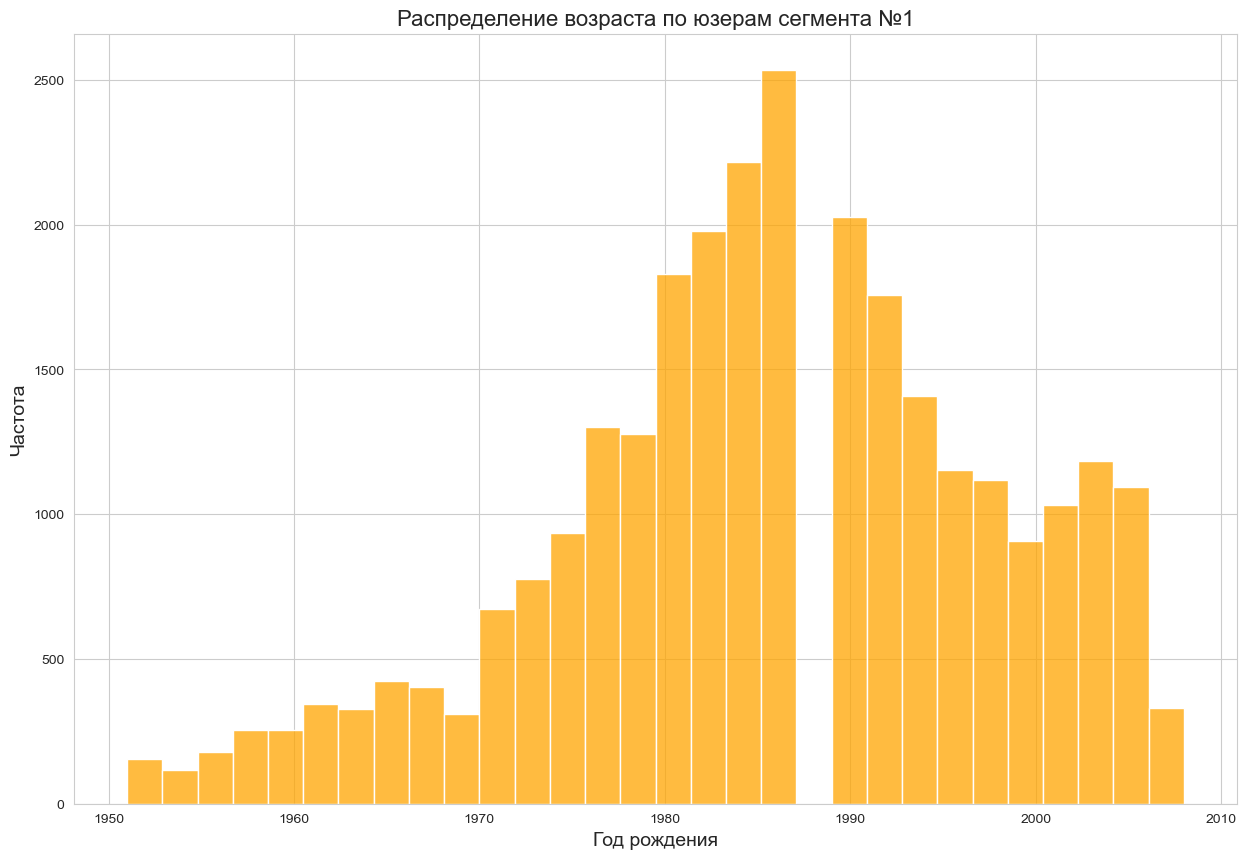

In [825]:
plt.figure(figsize=(15,10))

sns.histplot(data=age_users_df_1, x="year_birth", bins=30, color='orange')

plt.title('Распределение возраста по юзерам сегмента №1', size=16)
plt.xlabel('Год рождения', size=14)
plt.ylabel('Частота', size=14)

## Сегмент №2

In [613]:
segment_2 = segments.query('cluster == 2')

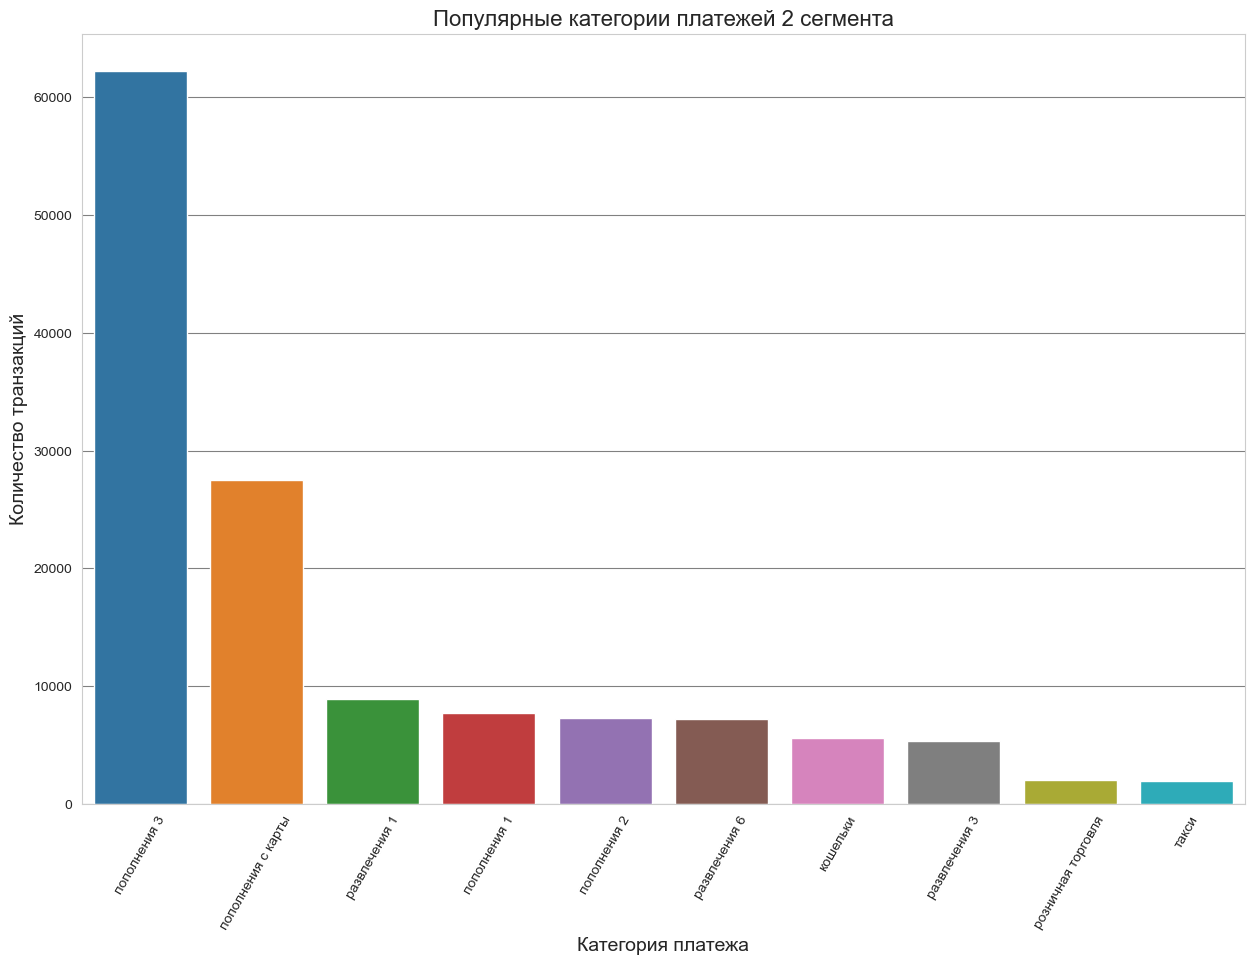

In [614]:
# Просмотр топа по категории платежей для 3 сегмента
top_cat_2 = segment_2.cat.value_counts().to_frame() \
                      .reset_index().head(10) \
                      .rename(columns={'index':'cat', 'cat':'cat_count'})

plt.figure(figsize=(15,10))
plt.grid(color='grey')
plt.xticks(rotation=60)
sns.barplot(data=top_cat_2, x='cat', y='cat_count')

plt.title('Популярные категории платежей 2 сегмента', size=16)
plt.xlabel('Категория платежа', size=14)
plt.ylabel('Количество транзакций', size=14)
plt.savefig("Категории_2_сегмент.svg")

## Retention rate

In [615]:
# Переводим в DateTime для удобства дальнейшей работы
segment_2['txn_minute'] = pd.to_datetime(segment_2.txn_minute)

C:\Users\Рома\AppData\Local\Temp\ipykernel_7064\668361012.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_2['txn_minute'] = pd.to_datetime(segment_2.txn_minute)


In [616]:
segment_2['month'] = segment_2['txn_minute'].dt.to_period("M")
segment_2['day'] = segment_2['txn_minute'].dt.to_period("D")

C:\Users\Рома\AppData\Local\Temp\ipykernel_7064\189690464.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_2['month'] = segment_2['txn_minute'].dt.to_period("M")
C:\Users\Рома\AppData\Local\Temp\ipykernel_7064\189690464.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_2['day'] = segment_2['txn_minute'].dt.to_period("D")


In [617]:
rr_segment_2 = segment_2.groupby('day', as_index=False) \
    .agg({'qw' : 'nunique'}) \
    .sort_values('day')

In [618]:
rr_segment_2['number_month'] = rr_segment_2['day'].dt.month

In [619]:
day_max_segment_2 = rr_segment_2.groupby(['number_month'], as_index=False).agg({'day' : 'max'}).rename(columns={'day' : 'day_max'})
day_min_segment_2 = rr_segment_2.groupby(['number_month'], as_index=False).agg({'day' : 'min'}).rename(columns={'day' : 'day_min'})

In [620]:
min_max_segment_2 = day_max_segment_2.merge(day_min_segment_2, how='inner', on='number_month')

to_join_max_segment_2 = rr_segment_2.rename(columns={'day' : 'day_max', 'qw' : 'max_qw'})

min_max_qw_segment_2 = min_max_segment_2.merge(to_join_max_segment_2, how='inner', on='day_max')

to_join_min_segment_2 = rr_segment_2.rename(columns={'day' : 'day_min', 'qw' : 'min_qw'})

min_qw_max_qw_segment_2 = min_max_qw_segment_2.merge(to_join_min_segment_2, how='inner', on='day_min')

RR_segment_2 = ((min_qw_max_qw_segment_2.max_qw / min_qw_max_qw_segment_2.min_qw) * 100).round(2)

RR_df_segment_2 = RR_segment_2.to_frame().reset_index().rename(columns={'index' : 'month', 0 : 'RR'})

In [621]:
RR_df_segment_2.head()

,month,RR
0,0,113.38
1,1,87.40
2,2,106.17
3,3,113.30
4,4,117.98


## Churn rate

In [622]:
churn_rate_segment_2 = (min_qw_max_qw_segment_2.min_qw - min_qw_max_qw_segment_2.max_qw) / min_qw_max_qw_segment_2.min_qw * 100

churn_rate_segment_2_df = churn_rate_segment_2.to_frame().reset_index().rename(columns={'index' : 'month', 0 : 'CR'})

In [623]:
churn_rate_segment_2_df.head()

,month,CR
0,0,-13.380282
1,1,12.601156
2,2,-6.165414
3,3,-13.304094
4,4,-17.977528


## revenue, уникальные юзеры, средний чек, количество транзакций

In [624]:
revenue_by_month_segment_2 = segment_2.groupby('month', as_index=False) \
    .agg({'amount' : 'sum'}) \
    .rename(columns={'amount' : 'revenue'})

In [625]:
uniq_month_segment_2 = segment_2.groupby('month', as_index=False) \
    .agg({'qw' : 'nunique'})

In [626]:
avg_check_by_month_segment_2 = segment_2.groupby('month', as_index=False) \
    .agg({'amount' : 'mean'}) \
    .rename(columns={'amount' : 'mean_avg'})

In [627]:
count_tranc_2 = segment_2.groupby('month', as_index=False) \
    .agg({'txn_id' : 'count'}) \
    .rename(columns={'txn_id' : 'tranc_count'})

## Частота транзакций

- Количество транзакций, совершенных пользователем за определенный месяц

In [628]:
transaction_frequency_2 = segment_2.groupby('month', as_index=False) \
    .agg({'txn_id' : 'count'}) \
    .rename(columns={'txn_id' : 'transaction_count'})

transaction_frequency_2['number_month'] = transaction_frequency_2['month'].dt.month

transaction_frequency_2.sort_values('transaction_count', ascending=False)

,month,transaction_count,number_month
5,2022-07,23399,7
9,2022-11,17378,11
4,2022-06,16361,6
8,2022-10,15851,10
1,2022-03,12758,3
3,2022-05,12049,5
2,2022-04,11394,4
6,2022-08,8286,8
7,2022-09,7927,9
0,2022-01,7234,1


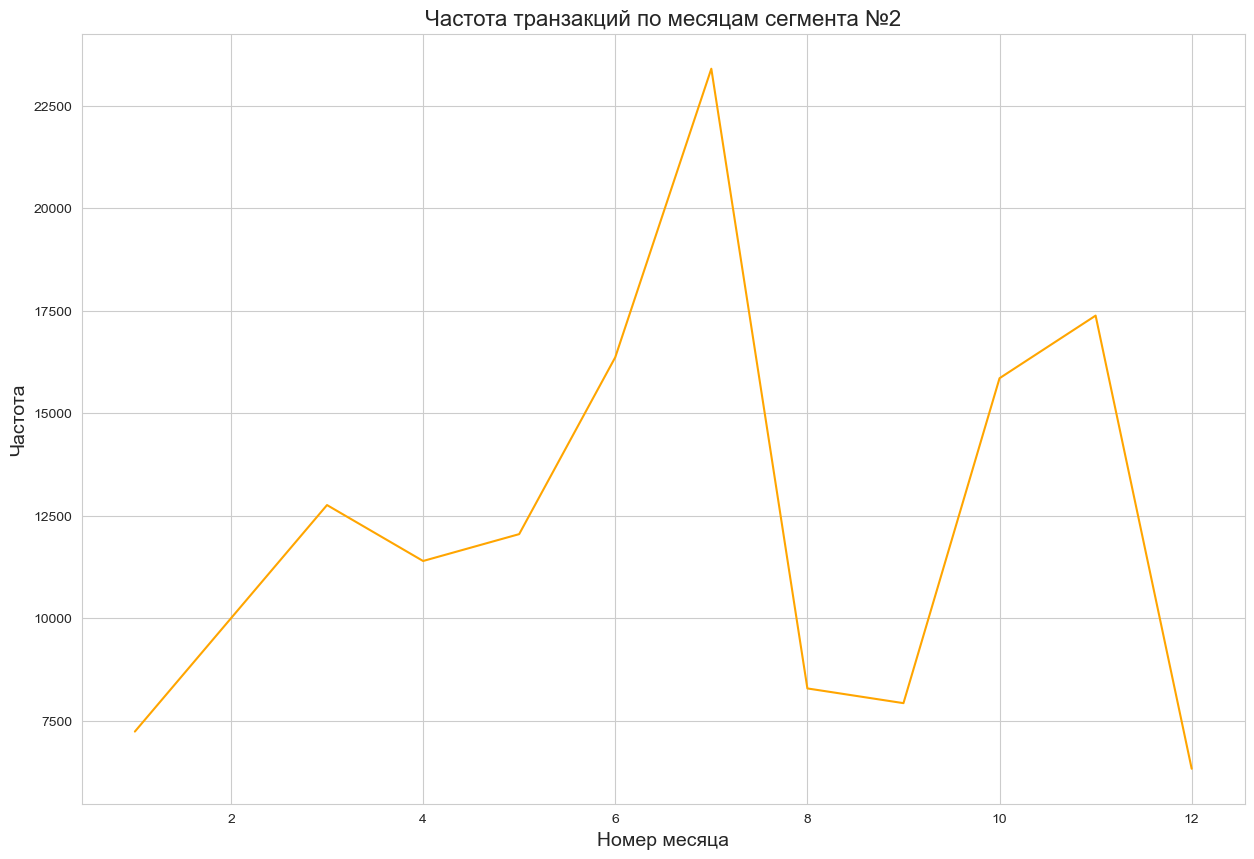

In [629]:
plt.figure(figsize=(15,10))

sns.lineplot(data=transaction_frequency_2, x='number_month', y='transaction_count', color = "orange")

plt.title('Частота транзакций по месяцам сегмента №2', size=16)
plt.xlabel('Номер месяца', size=14)
plt.ylabel('Частота', size=14)
plt.savefig("Категории_2_сегмент.svg")

## Средний размер транзакции

- Средняя сумма платежа, совершаемого пользователем за одну транзакцию

In [1100]:
average_transaction_size_2 = segment_2["amount"].mean()

round(average_transaction_size_2, 2)

2962.75

## Предпочительный продукт для платежей

In [1123]:
preferred_payment_product_2 = segment_2.groupby('product', as_index=False) \
    .agg({'qw' : 'nunique'}) \
    .rename(columns={'qw' : 'count_uniq_id'})

preferred_payment_product_2

# Пользователи используют только продукт QW

,product,count_uniq_id
0,QW,73089


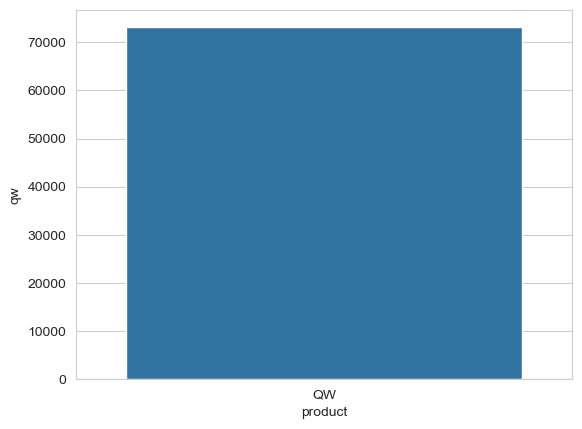

In [632]:
sns.barplot(data=preferred_payment_product_2, x="product", y="count_uniq_id")

plt.savefig("preferred_payment_product_2.svg")

## Предпочтительная категория платежей

In [1146]:
preferred_payment_category_2 = segment_2.groupby('cat', as_index=False) \
    .agg({'qw' : 'nunique'}) \
    .sort_values('qw', ascending=False)

preferred_payment_category_2

# Юзеры чаще используют категорию пополнений

,cat,qw
4,пополнения 3,37695
6,пополнения с карты,17587
3,пополнения 2,6372
7,развлечения 1,5362
10,развлечения 6,5194
2,пополнения 1,4712
0,кошельки,4075
8,развлечения 3,3488
11,розничная торговля,1638
13,такси,737


In [1162]:
clear_df_2 = [re.sub(r"\d+", "", x, flags=re.UNICODE).rstrip() for x in preferred_payment_category_2.cat]

preferred_payment_category_2['cat'] = clear_df_2

clear_pref_cat_2 = preferred_payment_category_2.groupby('cat', as_index=False) \
    .agg({'qw' : 'sum'}) \
    .sort_values('qw', ascending=False) \
    .rename(columns={'qw' : 'count_id'}) \
    .head()

clear_pref_cat_2

# Юзеры чаще используют категорию развлечений и переводов

,cat,count_id
2,пополнения,48903
3,пополнения с карты,17587
4,развлечения,14403
0,кошельки,4075
5,розничная торговля,1638


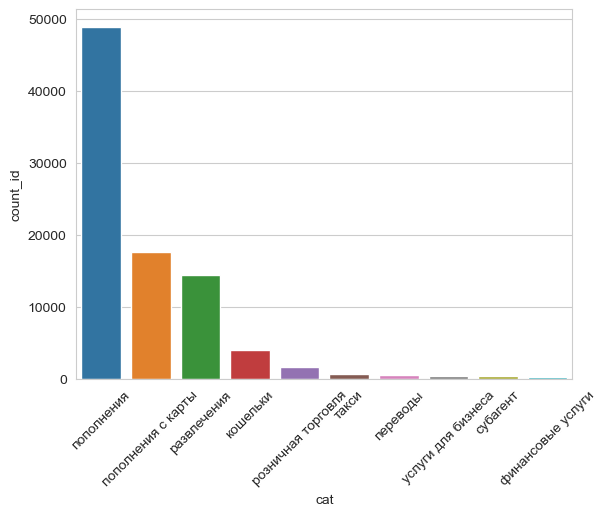

In [1150]:
sns.barplot(data=clear_pref_cat_2.head(10), x="cat", y="count_id")

plt.xticks(rotation=45)

plt.savefig("clear_pref_cat_2.svg")

## Общая сумма платежей по юзерам

In [636]:
total_sum_2 = segment_2.groupby('qw', as_index=False) \
    .agg({'amount' : 'sum'}) \
    .sort_values('amount', ascending=False)

total_sum_2.head()

,qw,amount
11880,1207485,791918.3125
24585,1853615,777272.8775
16145,1428156,770790.6325
23470,1803173,527640.7500
27594,1989693,503790.0000


## Общая сумма комиссий, на которых киви заработал (+)

In [637]:
plus_fee_2 = segment_2.query('total_fee > 0')

plus_fee_2['number_month'] = plus_fee_2['month'].dt.month

In [638]:
plus_total_fee_2 = plus_fee_2.groupby('number_month', as_index=False) \
    .agg({'total_fee' : 'sum'}) \
    .sort_values('total_fee', ascending=False)

plus_total_fee_2.head()

# Как видим, мы не заработали на пользователях сегмента №2

,number_month,total_fee


## Общая сумма комиссий, на которых киви потерял (-)

In [639]:
minus_fee_2 = segment_2.query('total_fee < 0')

minus_fee_2['number_month'] = minus_fee_2['month'].dt.month

In [640]:
mines_total_fee_2 = minus_fee_2.groupby('number_month', as_index=False) \
    .agg({'total_fee' : 'sum'}) \
    .sort_values('total_fee', ascending=False)

mines_total_fee_2.tail()

,number_month,total_fee
2,4,-199797.355170
4,6,-283188.620600
8,10,-288003.263574
9,11,-308557.349126
5,7,-409670.695177


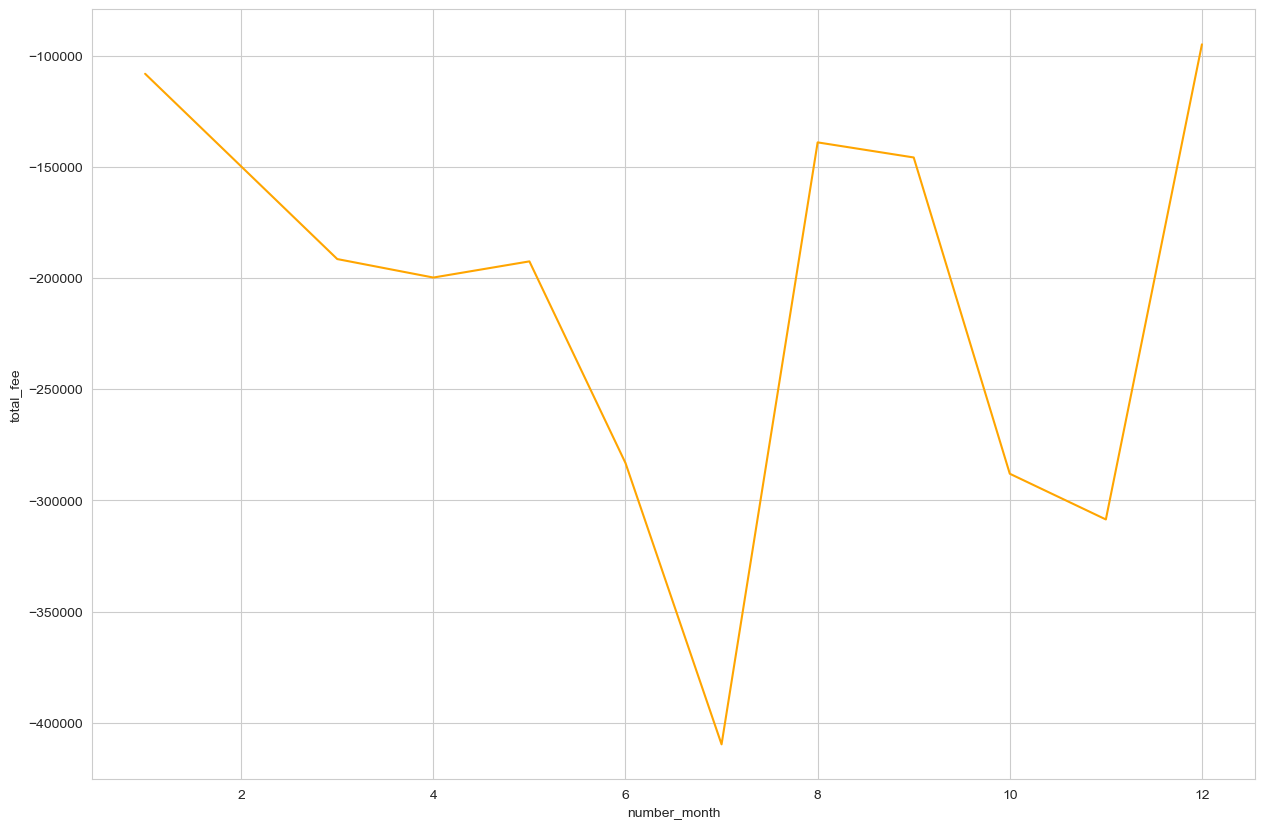

In [641]:
plt.figure(figsize=(15,10))

sns.lineplot(data=mines_total_fee_2, x='number_month', y='total_fee', color = "orange")

plt.savefig("mines_total_fee_2.svg")

## Временной интервал между транзакциями

- Время, прошедшее между двумя последовательными транзакциями пользователя.

In [642]:
segment_diff_2 = segment_2.sort_values(by=["qw", "txn_minute"])

In [643]:
segment_diff_2["time_interval"] = segment_diff_2.groupby("qw")["txn_minute"].diff()

segment_diff_2[["qw", "txn_minute", "time_interval"]].tail()

,qw,txn_minute,time_interval
226146,4630945,2022-06-17 17:10:00,1 days 09:22:00
67959,4630945,2022-06-25 19:42:00,8 days 02:32:00
436435,4630945,2022-07-27 12:22:00,31 days 16:40:00
401137,4630945,2022-11-21 16:47:00,117 days 04:25:00
820351,4631120,2022-10-05 07:04:00,NaT


In [644]:
segment_diff_2[segment_diff_2.time_interval > '0 days 00:00:00'].sort_values('time_interval').head()

,txn_id,txn_minute,qw,txn_type,product,cat,amount,client_fee,payout_fee,interchange_fee,...,payin_fee,cluster,sex,nationality,year_birth,total_fee,month,number_month,day,time_interval
945368,125264110,2022-04-11 13:32:00,96528,payin,QW,пополнения 1,65983.61,0.0,-0.0,0.0,...,-329.91805,2,1.0,0.0,1989.0,-329.91805,2022-04,4,2022-04-11,0 days 00:01:00
949888,183897664,2022-12-15 15:13:00,859189,payin,QW,пополнения 1,87.50,0.0,-0.0,0.0,...,-0.43750,2,1.0,1.0,1961.0,-0.43750,2022-12,12,2022-12-15,0 days 00:01:00
742213,120441277,2022-03-20 00:17:00,3606224,payin,QW,субагент,26248.25,0.0,-0.0,0.0,...,-131.24125,2,1.0,1.0,1991.0,-131.24125,2022-03,3,2022-03-20,0 days 00:01:00
641933,156123226,2022-08-23 22:42:00,2636591,payin,QW,пополнения 4,1627.50,0.0,-0.0,0.0,...,-1.62750,2,1.0,1.0,1999.0,-1.62750,2022-08,8,2022-08-23,0 days 00:01:00
829674,178547782,2022-11-24 01:02:00,868334,payin,QW,пополнения 1,8750.00,0.0,-0.0,0.0,...,-43.75000,2,1.0,1.0,1986.0,-43.75000,2022-11,11,2022-11-24,0 days 00:01:00


In [1075]:
all_users_df_2 = segment_diff_2.groupby('month', as_index=False) \
    .agg({'time_interval' : 'mean'})

all_users_df_2['number_month'] = all_users_df_2['month'].dt.month

days_interval = [str(x).split(' ')[0] for x in all_users_df_2.time_interval]

all_users_df_2['days_interval'] = days_interval

In [1079]:
all_users_df_2.sort_values('month').head()

,month,time_interval,number_month,days_interval
0,2022-01,2 days 03:11:47.001321003,1,2
1,2022-03,21 days 22:36:44.088830829,3,21
2,2022-04,22 days 21:13:52.026476578,4,22
3,2022-05,31 days 16:50:48.840872375,5,31
4,2022-06,39 days 22:15:33.319576992,6,39


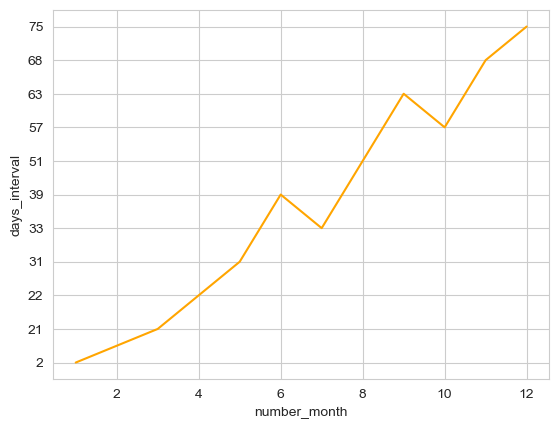

In [1076]:
all_users_df_2 = all_users_df_2.sort_values('days_interval', ascending=False)

sns.lineplot(data=all_users_df_2, x='number_month', y='days_interval', color = "orange")

plt.savefig("all_users_df_2.svg")

## Типы транзакций

- Какие типы транзакций пользователь обычно совершает

In [1170]:
transaction_types_2 = segment_2.groupby('txn_type', as_index=False) \
    .agg({'qw' : 'nunique'}) \
    .rename(columns={'qw' : 'count_id'})

transaction_types_2.head()

# Тип операции нашего сегмента №2 только пополнение, что объсняет наши отрицательные комиссии,
    #поскольку комиссия за снятие обычно выше

,txn_type,count_id
0,payin,73089


## Приблизительная продолжительность сессии юзера

- Предположим, что все транзакции пользователя, совершенные в течение 30 минут после предыдущей транзакции, являются частью одной сессии. Таким образом, можно объединить все транзакции, совершенные в течение 30 минут в одну сессию и вычислить продолжительность этой сессии

In [648]:
approximate_session_2 = segment_diff_2.copy()

# заполнение пропущенных значений в столбце "time_interval" значением 0 (для первой транзакции пользователя)
approximate_session_2['time_interval'] = approximate_session_2['time_interval'].fillna(pd.Timedelta(seconds=0))

In [649]:
# определение сессий (предполагаем, что все транзакции, совершенные в течение 30 минут после предыдущей транзакции,
# являются частью одной сессии)
approximate_session_2['session'] = (approximate_session_2['time_interval'] > pd.Timedelta(minutes=30)).cumsum()

# расчет продолжительности каждой сессии
approximate_session_2['approximate'] = approximate_session_2.groupby(['qw', 'session'])['time_interval'].cumsum()

# расчет средней продолжительности сессии
mean_session_duration_2 = approximate_session_2['approximate'].mean()

print('Средняя продолжительность сессии 2 сегмента:', mean_session_duration_2)

Средняя продолжительность сессии 2 сегмента: 22 days 11:51:45.404238477


## Пиковый день / время

In [650]:
pic_day_time_2 = segment_2.copy()

In [651]:
pic_day_time_2['txn_minute'] = pd.to_datetime(pic_day_time_2['txn_minute'])

pic_day_time_2['day'] = pic_day_time_2['txn_minute'].dt.dayofweek

# Подсчет количества транзакций для каждого дня недели
transactions_by_day_2 = pic_day_time_2.groupby('day').size()

# Поиск пикового дня
peak_day_2 = transactions_by_day_2.idxmax()
peak_day_count_2 = transactions_by_day_2.max()

print("Пиковый день:", peak_day_2)
print("Количество транзакций:", peak_day_count_2)

Пиковый день: 0
Количество транзакций: 35459


Инсайт: юзеры 2 сегмента чаще всего совершают транзакции в понедельник

## Сезонность

In [652]:
seasonality_2 = segment_2.copy()

In [653]:
seasonality_2['txn_minute'] = pd.to_datetime(seasonality_2['txn_minute'])

seasonality_2["month"] = seasonality_2["txn_minute"].dt.month

In [654]:
transactions_per_month_2 = seasonality_2.groupby(seasonality_2['txn_minute'].dt.strftime('%Y-%m'))['txn_id'].count()

transactions_per_month_2.nlargest(3)

#Топ 3 месяца по количеству транзакций

txn_minute
2022-07    23399
2022-11    17378
2022-06    16361
Name: txn_id, dtype: int64

## Частота использования продуктов и категорий

- 1 означает, что пользователь не менял продукт или категорию и пользовался ими все время
- 2 означает, что пользователь 1 раз поменял продукт или категорию
- 3 означает, что пользователь 2 раза поменял продукт или категорию
и т.д

In [655]:
# Группировка данных по ID пользователя и расчет количества уникальных значений для каждой колонки

user_counts_2 = segment_2.groupby('qw').nunique()

In [656]:
product_freq_2 = user_counts_2['product'].value_counts(normalize=True)

category_freq_2 = user_counts_2['cat'].value_counts(normalize=True)

In [657]:
product_freq_2

1    1.0
Name: product, dtype: float64

In [1090]:
round(category_freq_2, 4)

1    0.8287
2    0.1335
3    0.0307
4    0.0059
5    0.0011
6    0.0001
Name: cat, dtype: float64

## Распределение возраста пользаков

In [659]:
age_users_df_2 = segment_2.query('year_birth != 1988')

Text(0, 0.5, 'Частота')

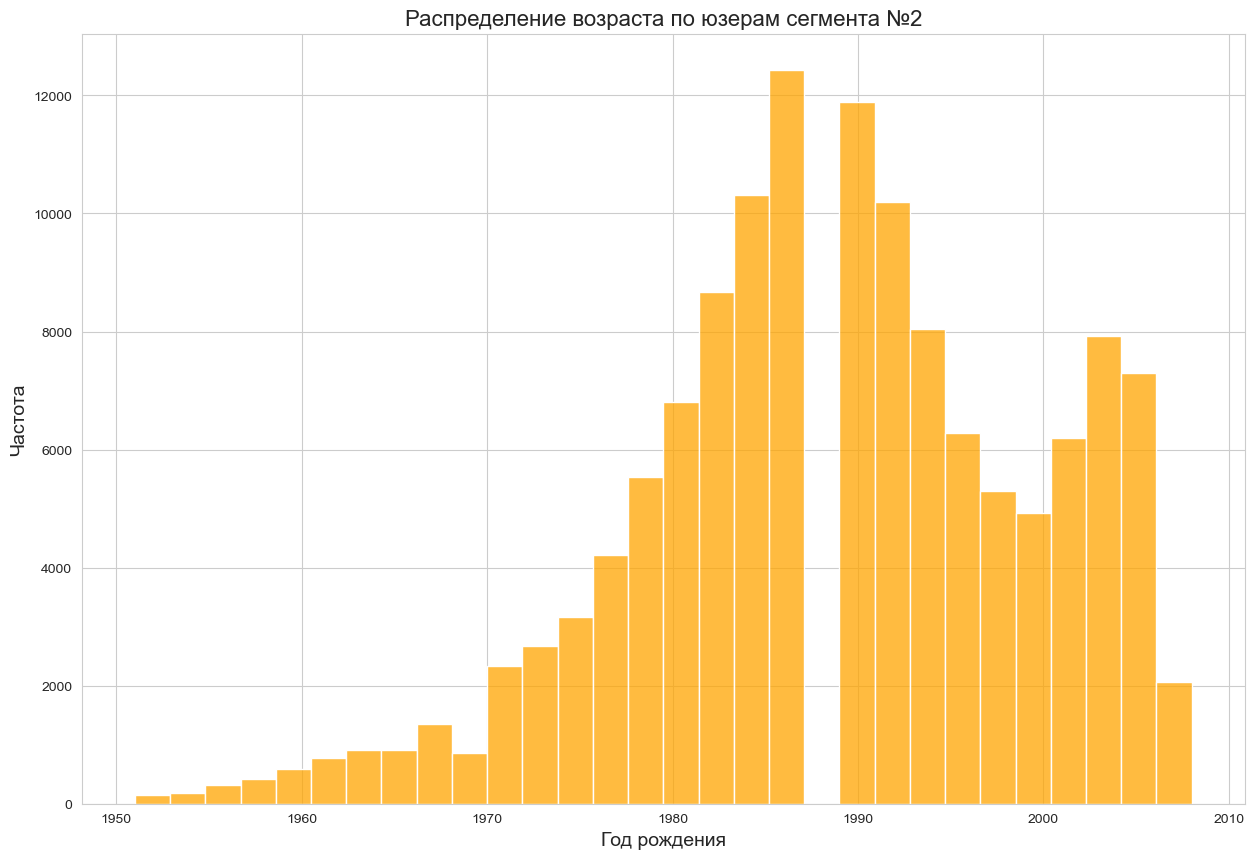

In [660]:
plt.figure(figsize=(15,10))

sns.histplot(data=age_users_df_2, x="year_birth", bins=30, color='orange')

plt.title('Распределение возраста по юзерам сегмента №2', size=16)
plt.xlabel('Год рождения', size=14)
plt.ylabel('Частота', size=14)

## Сегмент №3

In [661]:
segment_3 = segments.query('cluster == 3')

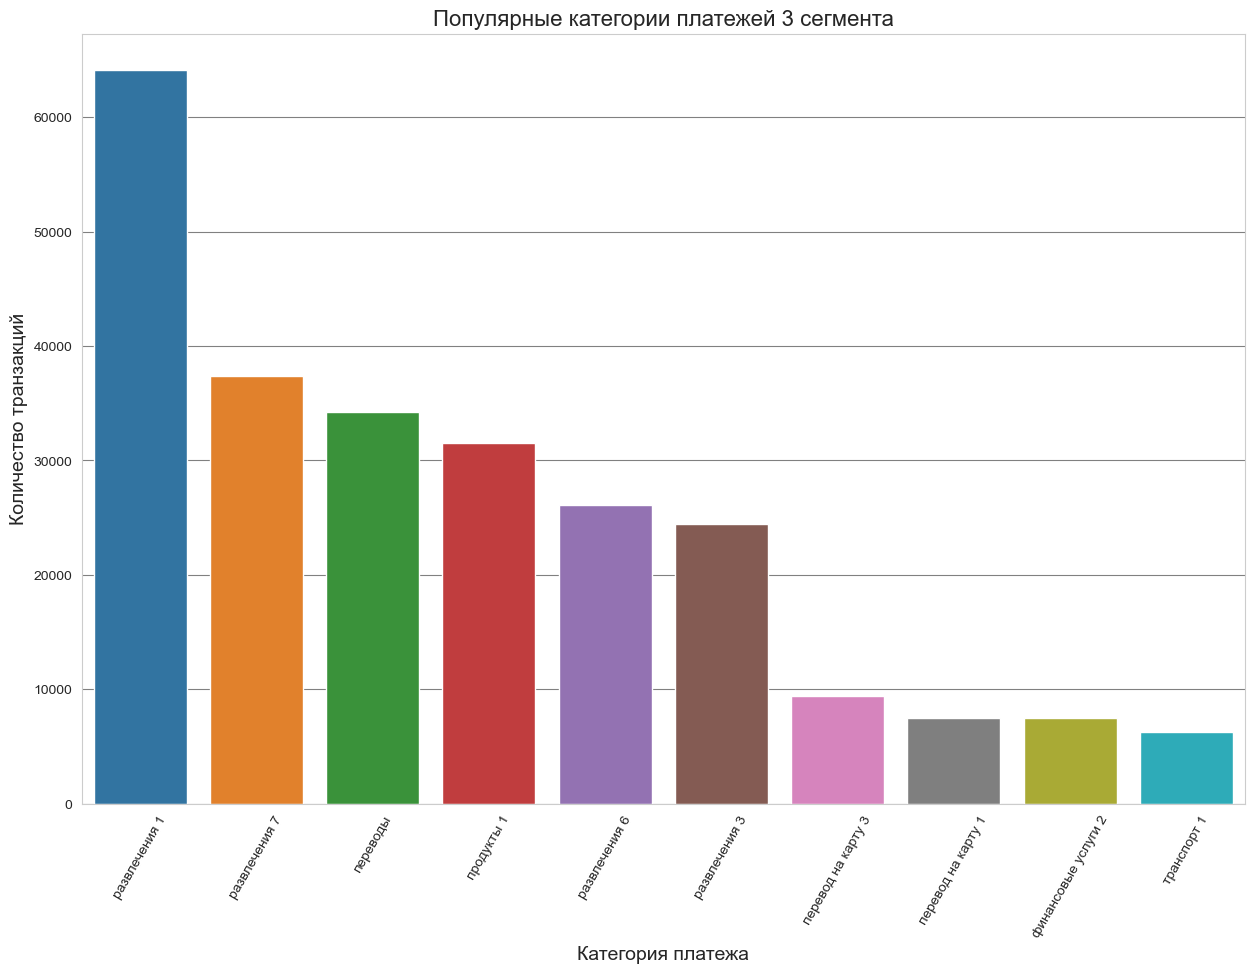

In [662]:
# Просмотр топа по категории платежей для 3 сегмента
top_cat_3 = segment_3.cat.value_counts().to_frame() \
                      .reset_index().head(10) \
                      .rename(columns={'index':'cat', 'cat':'cat_count'})

plt.figure(figsize=(15,10))
plt.grid(color='grey')
plt.xticks(rotation=60)
sns.barplot(data=top_cat_3, x='cat', y='cat_count')

plt.title('Популярные категории платежей 3 сегмента', size=16)
plt.xlabel('Категория платежа', size=14)
plt.ylabel('Количество транзакций', size=14)
plt.savefig("Категории_3_сегмент.svg")

In [663]:
segment_3.head()

,txn_id,txn_minute,qw,txn_type,product,cat,amount,client_fee,payout_fee,interchange_fee,paysys_fee,payin_fee,cluster,sex,nationality,year_birth,total_fee,month,number_month
5,141587514,2022-06-24 09:54:00,3618283,payout,QW,развлечения 3,350.0,7.00,-5.0,0.0000,-0.0000,-0.0,3,1.0,1.0,1989.0,2.000,2022-06,6
7,128063858,2022-04-24 12:32:00,902554,payout,Пластиковая карта,продукты 1,136.5,0.00,-0.0,2.0475,-1.6825,-0.0,3,0.0,1.0,2001.0,0.365,2022-04,4
10,131826206,2022-05-12 09:45:00,2818409,payout,Пластиковая карта,топливо,525.0,0.00,-0.0,7.8750,-3.6250,-0.0,3,0.0,1.0,1983.0,4.250,2022-05,5
24,147532754,2022-07-18 19:55:00,1218453,payout,QW,развлечения 3,164.5,3.29,-5.0,0.0000,-0.0000,-0.0,3,1.0,1.0,1991.0,-1.710,2022-07,7
37,141054757,2022-06-21 21:26:00,3458645,payout,QW,развлечения 1,1750.0,35.00,-0.0,0.0000,-0.0000,-0.0,3,1.0,1.0,1987.0,35.000,2022-06,6


## Retention rate

In [664]:
# Переводим в DateTime для удобства дальнейшей работы
segment_3['txn_minute'] = pd.to_datetime(segment_3.txn_minute)

C:\Users\Рома\AppData\Local\Temp\ipykernel_7064\1573016259.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_3['txn_minute'] = pd.to_datetime(segment_3.txn_minute)


In [665]:
segment_3['month'] = segment_3['txn_minute'].dt.to_period("M")
segment_3['day'] = segment_3['txn_minute'].dt.to_period("D")

C:\Users\Рома\AppData\Local\Temp\ipykernel_7064\2123739237.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_3['month'] = segment_3['txn_minute'].dt.to_period("M")
C:\Users\Рома\AppData\Local\Temp\ipykernel_7064\2123739237.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_3['day'] = segment_3['txn_minute'].dt.to_period("D")


In [666]:
rr_segment_3 = segment_3.groupby('day', as_index=False) \
    .agg({'qw' : 'nunique'}) \
    .sort_values('day')

In [667]:
rr_segment_3['number_month'] = rr_segment_3['day'].dt.month

In [668]:
rr_segment_3['number_month'] = rr_segment_3['day'].dt.month

In [669]:
day_max_segment_3 = rr_segment_3.groupby(['number_month'], as_index=False).agg({'day' : 'max'}).rename(columns={'day' : 'day_max'})
day_min_segment_3 = rr_segment_3.groupby(['number_month'], as_index=False).agg({'day' : 'min'}).rename(columns={'day' : 'day_min'})

In [670]:
min_max_segment_3 = day_max_segment_3.merge(day_min_segment_3, how='inner', on='number_month')

to_join_max_segment_3 = rr_segment_3.rename(columns={'day' : 'day_max', 'qw' : 'max_qw'})

min_max_qw_segment_3 = min_max_segment_3.merge(to_join_max_segment_3, how='inner', on='day_max')

to_join_min_segment_3 = rr_segment_3.rename(columns={'day' : 'day_min', 'qw' : 'min_qw'})

min_qw_max_qw_segment_3 = min_max_qw_segment_3.merge(to_join_min_segment_3, how='inner', on='day_min')

RR_segment_3 = ((min_qw_max_qw_segment_3.max_qw / min_qw_max_qw_segment_3.min_qw) * 100).round(2)

RR_df_segment_3 = RR_segment_3.to_frame().reset_index().rename(columns={'index' : 'month', 0 : 'RR'})

In [671]:
RR_df_segment_3.head()

,month,RR
0,0,100.81
1,1,84.77
2,2,106.08
3,3,110.89
4,4,108.82


## Churn rate

In [672]:
churn_rate_segment_3 = (min_qw_max_qw_segment_3.min_qw - min_qw_max_qw_segment_3.max_qw) / min_qw_max_qw_segment_3.min_qw * 100

churn_rate_segment_3_df = churn_rate_segment_3.to_frame().reset_index().rename(columns={'index' : 'month', 0 : 'CR'})

In [673]:
churn_rate_segment_3_df.head()

,month,CR
0,0,-0.808625
1,1,15.233161
2,2,-6.081548
3,3,-10.891089
4,4,-8.821788


## revenue, уникальные юзеры, средний чек, количество транзакций

In [674]:
revenue_by_month_segment_3 = segment_3.groupby('month', as_index=False) \
    .agg({'amount' : 'sum'}) \
    .rename(columns={'amount' : 'revenue'})

In [675]:
uniq_month_segment_3 = segment_3.groupby('month', as_index=False) \
    .agg({'qw' : 'nunique'})

In [676]:
avg_check_by_month_segment_3 = segment_3.groupby('month', as_index=False) \
    .agg({'amount' : 'mean'}) \
    .rename(columns={'amount' : 'mean_avg'})

In [677]:
count_tranc_3 = segment_3.groupby('month', as_index=False) \
    .agg({'txn_id' : 'count'}) \
    .rename(columns={'txn_id' : 'tranc_count'})

In [678]:
segment_3.head()

,txn_id,txn_minute,qw,txn_type,product,cat,amount,client_fee,payout_fee,interchange_fee,paysys_fee,payin_fee,cluster,sex,nationality,year_birth,total_fee,month,number_month,day
5,141587514,2022-06-24 09:54:00,3618283,payout,QW,развлечения 3,350.0,7.00,-5.0,0.0000,-0.0000,-0.0,3,1.0,1.0,1989.0,2.000,2022-06,6,2022-06-24
7,128063858,2022-04-24 12:32:00,902554,payout,Пластиковая карта,продукты 1,136.5,0.00,-0.0,2.0475,-1.6825,-0.0,3,0.0,1.0,2001.0,0.365,2022-04,4,2022-04-24
10,131826206,2022-05-12 09:45:00,2818409,payout,Пластиковая карта,топливо,525.0,0.00,-0.0,7.8750,-3.6250,-0.0,3,0.0,1.0,1983.0,4.250,2022-05,5,2022-05-12
24,147532754,2022-07-18 19:55:00,1218453,payout,QW,развлечения 3,164.5,3.29,-5.0,0.0000,-0.0000,-0.0,3,1.0,1.0,1991.0,-1.710,2022-07,7,2022-07-18
37,141054757,2022-06-21 21:26:00,3458645,payout,QW,развлечения 1,1750.0,35.00,-0.0,0.0000,-0.0000,-0.0,3,1.0,1.0,1987.0,35.000,2022-06,6,2022-06-21


## Частота транзакций

- Количество транзакций, совершенных пользователем за определенный месяц

In [679]:
transaction_frequency_3 = segment_3.groupby('month', as_index=False) \
    .agg({'txn_id' : 'count'}) \
    .rename(columns={'txn_id' : 'transaction_count'})

transaction_frequency_3['number_month'] = transaction_frequency_3['month'].dt.month

transaction_frequency_3.head()

,month,transaction_count,number_month
0,2022-01,14962,1
1,2022-03,27977,3
2,2022-04,25366,4
3,2022-05,27141,5
4,2022-06,37834,6


Text(0, 0.5, 'Частота')

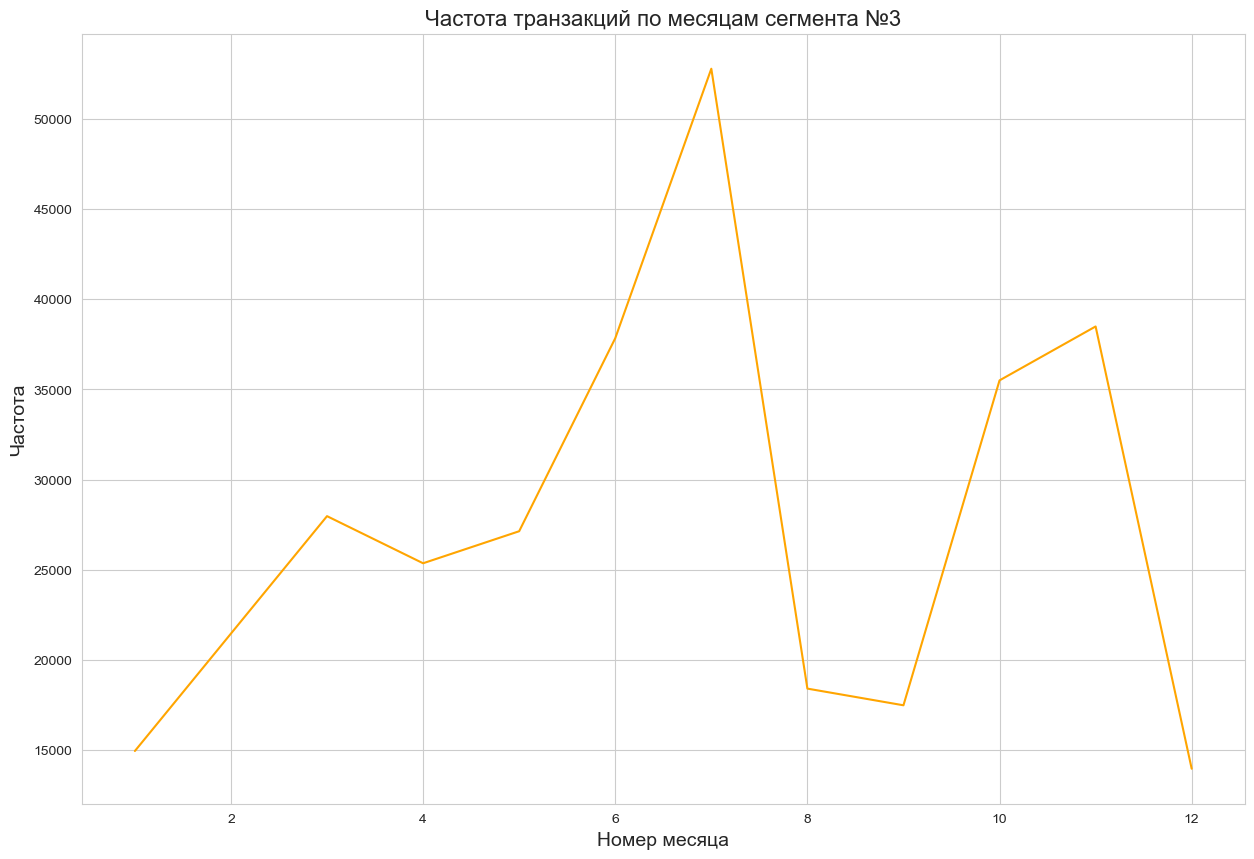

In [680]:
plt.figure(figsize=(15,10))

sns.lineplot(data=transaction_frequency_3, x='number_month', y='transaction_count', color = "orange")

plt.title('Частота транзакций по месяцам сегмента №3', size=16)
plt.xlabel('Номер месяца', size=14)
plt.ylabel('Частота', size=14)

## Средний размер транзакции

- Средняя сумма платежа, совершаемого пользователем за одну транзакцию

In [1097]:
average_transaction_size_3 = segment_3["amount"].mean()

round(average_transaction_size_3, 2)

2079.97

## Предпочтительный продукт для платежей

In [1124]:
preferred_payment_product_3 = segment_3.groupby('product', as_index=False) \
    .agg({'qw' : 'nunique'}) \
    .rename(columns={'qw' : 'count_uniq_id'})

preferred_payment_product_3

# Пользователи предпочительно используют продукт QW

,product,count_uniq_id
0,QW,101355
1,Виртуальная карта,16774
2,Пластиковая карта,13308


## Предпочтительная категория платежей

In [1151]:
preferred_payment_category_3  = segment_3.groupby('cat', as_index=False) \
    .agg({'qw' : 'nunique'}) \
    .sort_values('qw', ascending=False)

preferred_payment_category_3

# Юзеры чаще используют категорию развлечений

,cat,qw
22,переводы,21738
27,развлечения 1,21432
32,развлечения 6,20056
24,продукты 1,16038
33,развлечения 7,14036
...,...,...
8,ж/д билеты,5
23,подписки,5
15,купоны,3
47,туризм 1,2


In [1163]:
clear_df_3 = [re.sub(r"\d+", "", x, flags=re.UNICODE).rstrip() for x in preferred_payment_category_3.cat]

preferred_payment_category_3['cat'] = clear_df_3

clear_pref_cat_3 = preferred_payment_category_3.groupby('cat', as_index=False) \
    .agg({'qw' : 'sum'}) \
    .sort_values('qw', ascending=False) \
    .rename(columns={'qw' : 'count_id'}) \
    .head()

clear_pref_cat_3

# Юзеры чаще используют категорию развлечений и переводов

,cat,count_id
23,развлечения,72070
19,переводы,21738
21,продукты,20706
18,перевод на карту,16448
35,услуги для бизнеса,6693


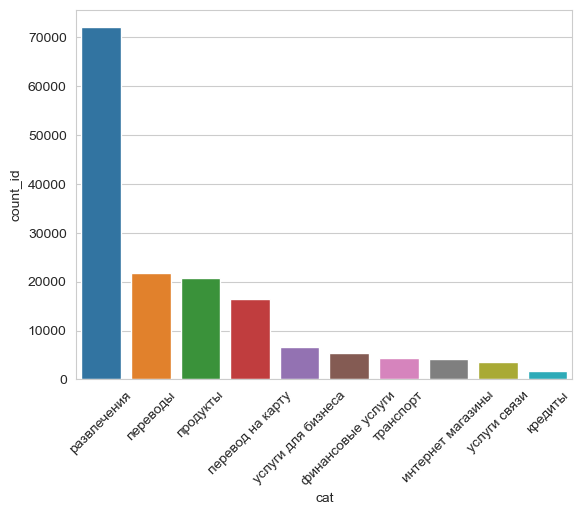

In [1154]:
sns.barplot(data=clear_pref_cat_3.head(10), x="cat", y="count_id")

plt.xticks(rotation=45)

plt.savefig('clear_pref_cat_3.svg')

## Общая сумма платежей по юзерам

In [686]:
total_sum_3 = segment_3.groupby('qw', as_index=False) \
    .agg({'amount' : 'sum'}) \
    .sort_values('amount', ascending=False)

total_sum_3.head()

,qw,amount
40443,1853615,1.122000e+06
93136,3606224,1.077027e+06
113686,4270456,9.932904e+05
103932,3911018,8.793662e+05
4521,711026,8.750000e+05


## Общая сумма комиссий, на которых киви заработал (+)

In [687]:
plus_fee_3 = segment_3.query('total_fee > 0')

plus_fee_3['number_month'] = plus_fee_3['month'].dt.month

C:\Users\Рома\AppData\Local\Temp\ipykernel_7064\139320134.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plus_fee_3['number_month'] = plus_fee_3['month'].dt.month


In [688]:
plus_total_fee_3 = plus_fee_3.groupby('number_month', as_index=False) \
    .agg({'total_fee' : 'sum'}) \
    .sort_values('total_fee', ascending=False)

plus_total_fee_3.head()

# Как видим, мы неплохо так заработали на пользователях сегмента №3

,number_month,total_fee
5,7,1.422325e+06
9,11,1.160304e+06
8,10,1.008339e+06
4,6,9.649174e+05
3,5,6.843514e+05


## Общая сумма комиссий, на которых киви потерял (-)

In [689]:
minus_fee_3 = segment_3.query('total_fee < 0')

minus_fee_3['number_month'] = minus_fee_3['month'].dt.month

C:\Users\Рома\AppData\Local\Temp\ipykernel_7064\1969641349.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  minus_fee_3['number_month'] = minus_fee_3['month'].dt.month


In [690]:
mines_total_fee_3 = minus_fee_3.groupby('number_month', as_index=False) \
    .agg({'total_fee' : 'sum'}) \
    .sort_values('total_fee', ascending=False)

mines_total_fee_3.tail()

,number_month,total_fee
8,10,-12165.898745
1,3,-12185.427535
9,11,-14210.478037
4,6,-15304.034573
5,7,-20916.757105


## Временной интервал между транзакциями

- Время, прошедшее между двумя последовательными транзакциями пользователя.

In [691]:
segment_diff_3 = segment_3.sort_values(by=["qw", "txn_minute"])

In [692]:
segment_diff_3["time_interval"] = segment_diff_3.groupby("qw")["txn_minute"].diff()

segment_diff_3[["qw", "txn_minute", "time_interval"]].tail()

,qw,txn_minute,time_interval
465609,4629823,2022-04-24 18:29:00,NaT
795753,4629823,2022-06-13 14:34:00,49 days 20:05:00
362040,4629823,2022-06-15 19:02:00,2 days 04:28:00
622971,4630276,2022-03-15 19:18:00,NaT
258280,4630643,2022-09-24 11:27:00,NaT


In [693]:
segment_diff_3[segment_diff_3.time_interval > '0 days 00:00:00'].sort_values('time_interval').head()

,txn_id,txn_minute,qw,txn_type,product,cat,amount,client_fee,payout_fee,interchange_fee,...,payin_fee,cluster,sex,nationality,year_birth,total_fee,month,number_month,day,time_interval
485966,167167066,2022-10-09 16:31:00,3550308,payout,QW,переводы,849.275,0.0,-0.00,0.0,...,-0.0,3,1.0,1.0,1992.0,0.00,2022-10,10,2022-10-09,0 days 00:01:00
923155,121347480,2022-03-23 22:58:00,1788967,payout,QW,переводы,880.600,0.0,-0.00,0.0,...,-0.0,3,0.0,1.0,1993.0,0.00,2022-03,3,2022-03-23,0 days 00:01:00
706203,132191129,2022-05-13 21:05:00,4075285,payout,QW,переводы,332.500,0.0,-0.00,0.0,...,-0.0,3,1.0,1.0,1996.0,0.00,2022-05,5,2022-05-13,0 days 00:01:00
207536,142326747,2022-06-27 11:23:00,1788967,payout,QW,переводы,9184.945,0.0,-0.00,0.0,...,-0.0,3,0.0,1.0,1993.0,0.00,2022-06,6,2022-06-27,0 days 00:01:00
102306,144026745,2022-07-04 11:26:00,2867282,payout,QW,перевод на карту 1,4025.000,80.5,-40.25,0.0,...,-0.0,3,1.0,1.0,1983.0,40.25,2022-07,7,2022-07-04,0 days 00:01:00


In [1080]:
all_users_df_3 = segment_diff_3.groupby('month', as_index=False) \
    .agg({'time_interval' : 'mean'})

all_users_df_3['number_month'] = all_users_df_3['month'].dt.month

days_interval_3 = [str(x).split(' ')[0] for x in all_users_df_2.time_interval]

all_users_df_3['days_interval_3'] = days_interval_3

In [1085]:
all_users_df_3.head()

,month,time_interval,number_month,days_interval_3
0,2022-01,1 days 20:27:28.742647058,1,75
1,2022-03,18 days 14:24:06.863817558,3,68
2,2022-04,18 days 09:30:04.923583353,4,63
3,2022-05,24 days 21:20:43.407053968,5,57
4,2022-06,30 days 11:36:20.989327460,6,51


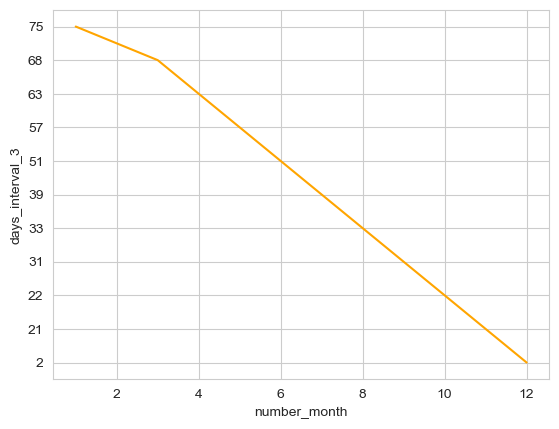

In [1084]:
all_users_df_3 = all_users_df_3.sort_values('days_interval_3', ascending=False)

sns.lineplot(data=all_users_df_3, x='number_month', y='days_interval_3', color = "orange")

plt.savefig("all_users_df_3.svg")

## Типы транзакций

- Какие типы транзакций пользователь обычно совершает

In [1164]:
transaction_types_3 = segment_3.groupby('txn_type', as_index=False) \
    .agg({'qw' : 'nunique'}) \
    .rename(columns={'qw' : 'count_id'})

transaction_types_3.head()

# Тип операции нашего 3 сегмента только снятие, что объсняет нашу выручку, поскольку комиссия за снятие обычно выше

,txn_type,count_id
0,payout,118874


## Приблизительная продолжительность сессии юзера

- Предположим, что все транзакции пользователя, совершенные в течение 30 минут после предыдущей транзакции, являются частью одной сессии. Таким образом, можно объединить все транзакции, совершенные в течение 30 минут в одну сессию и вычислить продолжительность этой сессии

In [695]:
approximate_session_3 = segment_diff_3.copy()

# заполнение пропущенных значений в столбце "time_interval" значением 0 (для первой транзакции пользователя)
approximate_session_3['time_interval'] = approximate_session_3['time_interval'].fillna(pd.Timedelta(seconds=0))

In [696]:
# определение сессий (предполагаем, что все транзакции, совершенные в течение 30 минут после предыдущей транзакции,
# являются частью одной сессии)
approximate_session_3['session'] = (approximate_session_3['time_interval'] > pd.Timedelta(minutes=30)).cumsum()

# расчет продолжительности каждой сессии
approximate_session_3['approximate'] = approximate_session_3.groupby(['qw', 'session'])['time_interval'].cumsum()

# расчет средней продолжительности сессии
mean_session_duration_3 = approximate_session_3['approximate'].mean()

print('Средняя продолжительность сессии 3 сегмента:', mean_session_duration_3)

Средняя продолжительность сессии 3 сегмента: 21 days 22:23:49.508638908


## Пиковый день / время

In [697]:
pic_day_time_3 = segment_3.copy()

In [698]:
pic_day_time_3['txn_minute'] = pd.to_datetime(pic_day_time_3['txn_minute'])

pic_day_time_3['day'] = pic_day_time_3['txn_minute'].dt.dayofweek

# Подсчет количества транзакций для каждого дня недели
transactions_by_day_3 = pic_day_time_3.groupby('day').size()

# Поиск пикового дня
peak_day_3 = transactions_by_day_3.idxmax()
peak_day_count_3 = transactions_by_day_3.max()

print("Пиковый день:", peak_day_3)
print("Количество транзакций:", peak_day_count_3)

Пиковый день: 0
Количество транзакций: 79178


Инсайт: юзеры 3 сегмента чаще всего совершают транзакции в понедельник

## Сезонность

In [699]:
seasonality_3 = segment_3.copy()

In [700]:
seasonality_3['txn_minute'] = pd.to_datetime(seasonality_3['txn_minute'])

seasonality_3["month"] = seasonality_3["txn_minute"].dt.month

In [701]:
transactions_per_month_3 = seasonality_3.groupby(seasonality_3['txn_minute'].dt.strftime('%Y-%m'))['txn_id'].count()

transactions_per_month_3.nlargest(3)

#Топ 3 месяца по количеству транзакций

txn_minute
2022-07    52770
2022-11    38488
2022-06    37834
Name: txn_id, dtype: int64

## Частота использования продуктов и категорий

- 1 означает, что пользователь не менял продукт или категорию и пользовался ими все время
- 2 означает, что пользователь 1 раз поменял продукт или категорию
- 3 означает, что пользователь 2 раза поменял продукт или категорию
и т.д

In [702]:
# Группировка данных по ID пользователя и расчет количества уникальных значений для каждой колонки

user_counts_3 = segment_3.groupby('qw').nunique()

In [703]:
product_freq_3 = user_counts_3['product'].value_counts(normalize=True)

category_freq_3 = user_counts_3['cat'].value_counts(normalize=True)

In [1091]:
round(product_freq_3, 4)

1    0.8974
2    0.0995
3    0.0031
Name: product, dtype: float64

In [1092]:
round(category_freq_3, 4)

1     0.7253
2     0.1715
3     0.0572
4     0.0220
5     0.0095
0     0.0066
6     0.0045
7     0.0019
8     0.0007
9     0.0004
11    0.0002
10    0.0001
13    0.0000
12    0.0000
14    0.0000
Name: cat, dtype: float64

## Распределение возраста пользаков

In [838]:
age_users_df_3 = segment_3.query('year_birth != 1988')

Text(0, 0.5, 'Частота')

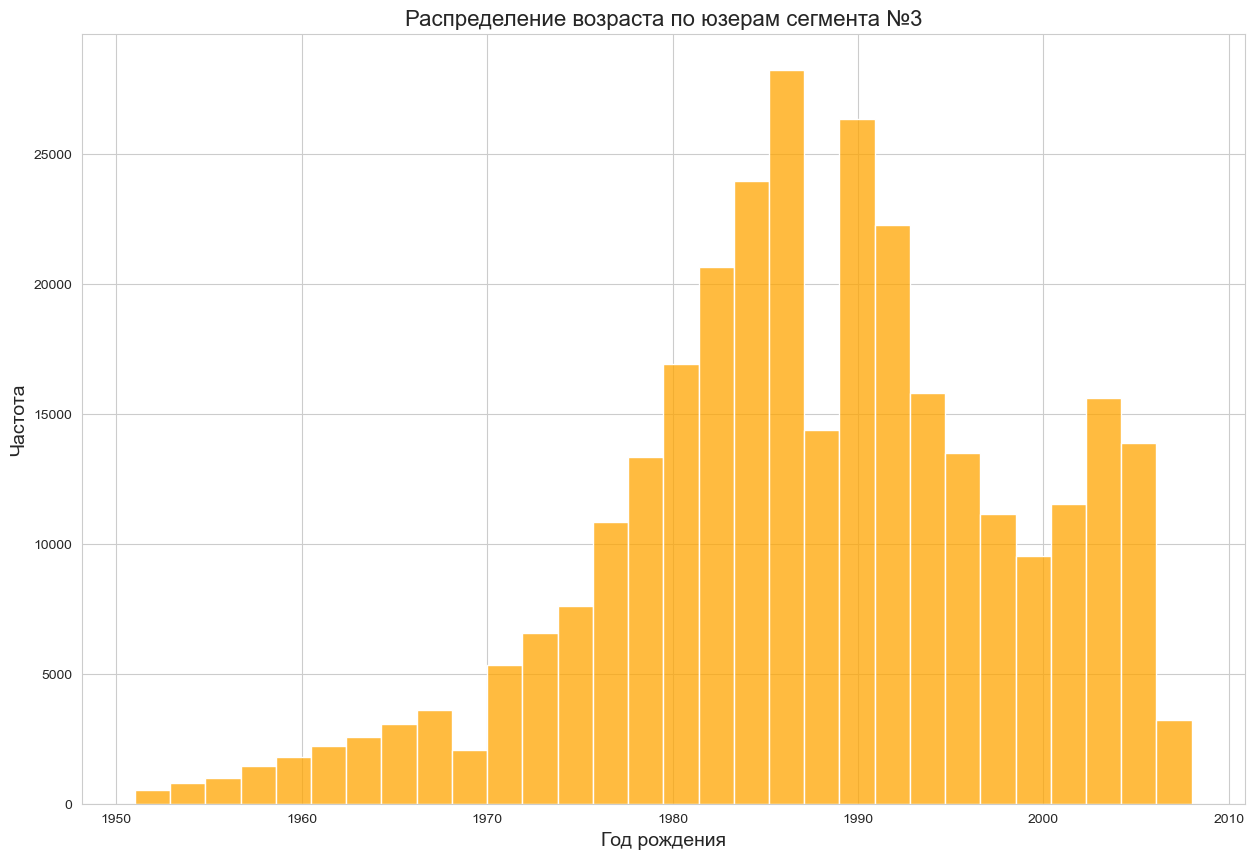

In [706]:
plt.figure(figsize=(15,10))

sns.histplot(data=segment_3, x="year_birth", bins=30, color='orange')

plt.title('Распределение возраста по юзерам сегмента №3', size=16)
plt.xlabel('Год рождения', size=14)
plt.ylabel('Частота', size=14)

### Дополнения к EDA

### Чистые категории

In [707]:
clear_main_df = [re.sub(r"\d+", "", str(x), flags=re.UNICODE).rstrip() for x in main_df.cat]

In [708]:
main_df['cat'] = clear_main_df

In [723]:
clear_main_cat.describe()

,qw
count,44.000000
mean,13367.090909
std,33972.626681
min,6.000000
25%,107.000000
50%,1756.000000
75%,6702.000000
max,171742.000000


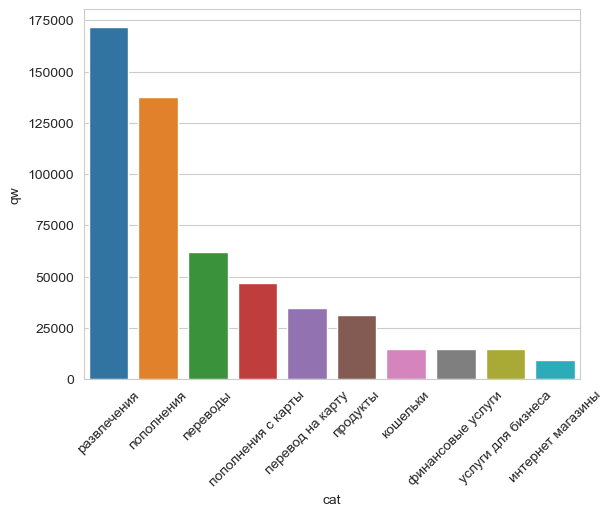

In [885]:
clear_main_cat = main_df.groupby('cat', as_index=False) \
    .agg({'qw' : 'nunique'}) \
    .sort_values('qw', ascending=False)

clear_main_cat.head(10)

# Юзеры чаще используют категорию развлечений и переводов

sns.barplot(data=clear_main_cat.head(10), x="cat", y="qw")

plt.xticks(rotation=45)
plt.savefig('clear_head_cat.svg')

### Пользаки по продуктам

In [710]:
uniq_product = main_df.groupby('product', as_index=False) \
    .agg({'qw' : 'nunique'}) \
    .rename(columns={'product' : 'Продукт Qiwi', 'qw' : 'Кол-во уникальных пользователей'})

In [711]:
uniq_product

,Продукт Qiwi,Кол-во уникальных пользователей
0,QW,382926
1,Виртуальная карта,30313
2,Пластиковая карта,19594


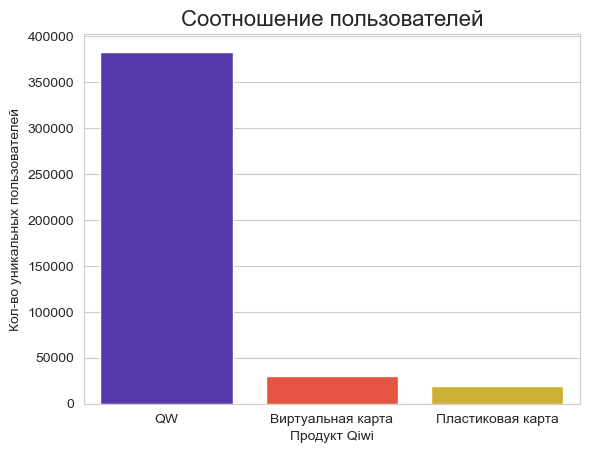

In [712]:
sns.barplot(data=uniq_product, x="Продукт Qiwi", y="Кол-во уникальных пользователей", palette='CMRmap')

plt.title('Соотношение пользователей', size=16)
plt.savefig("uniq_product.svg")

### Объем транзакций по месяцам в разбивке по продуктам

In [240]:
segments['txn_minute'] = pd.to_datetime(segments.txn_minute)
segments['month'] = segments['txn_minute'].dt.to_period("M")
segments['number_month'] = segments['month'].dt.month

In [248]:
sum_amount = segments.groupby(['number_month', 'product'], as_index=False) \
    .agg({'amount' : 'sum'}) \
    .rename(columns={'number_month' : 'Месяц', 'amount' : 'Объем транзакций'})

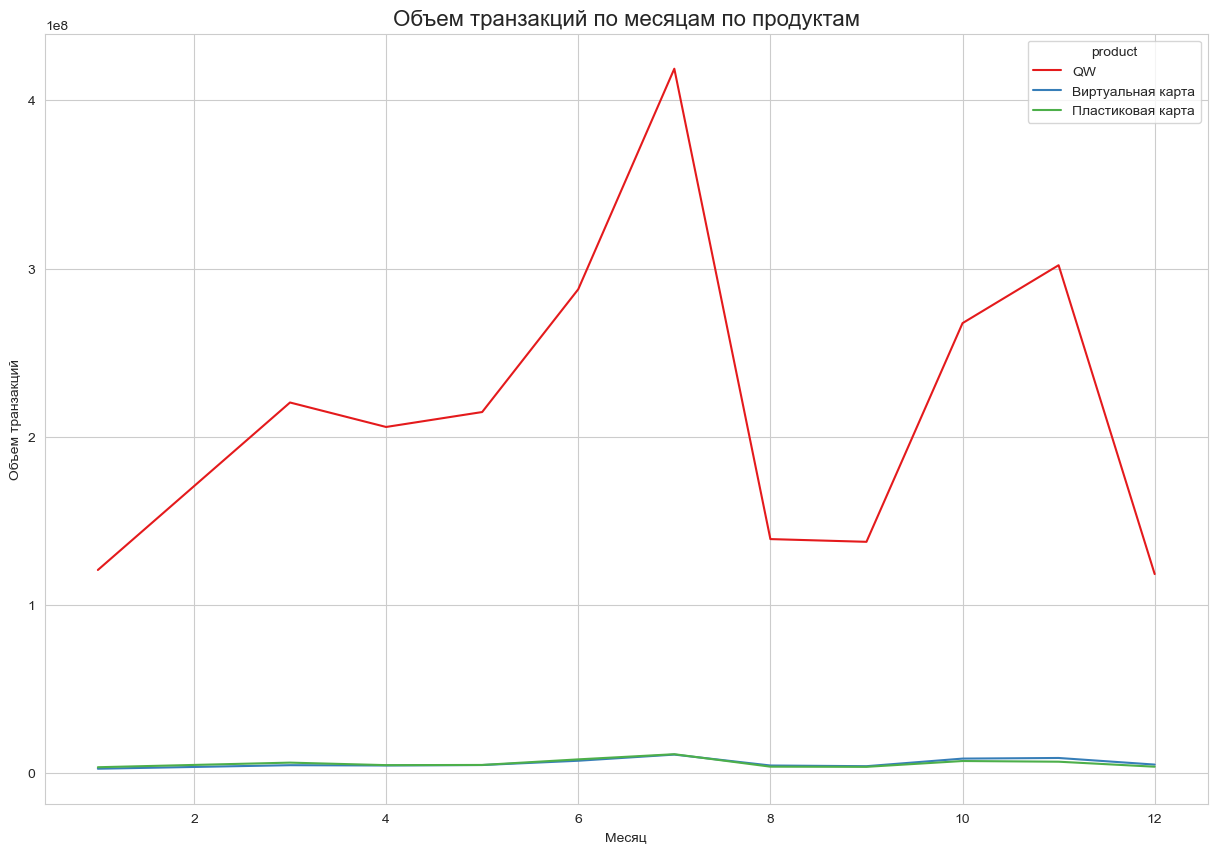

In [253]:
plt.figure(figsize=(15,10))

sns.lineplot(data=sum_amount, x='Месяц', y='Объем транзакций', hue='product', palette = "Set1")

plt.title('Объем транзакций по месяцам по продуктам', size=16)
plt.savefig("sum_amount.svg")

### Выручка по месяцам

In [328]:
rev_month = segments.query('client_fee > 0 & interchange_fee > 0')

In [336]:
graf_rev_month = rev_month.groupby(['number_month', 'product'], as_index=False) \
    .agg({'client_fee' : 'sum', 'interchange_fee' : 'sum'}) \
    .rename(columns={'number_month' : 'Месяц', 'amount' : 'Прибыль по месяцам'})

In [339]:
graf_rev_month['total_pus'] = graf_rev_month.client_fee + graf_rev_month.interchange_fee

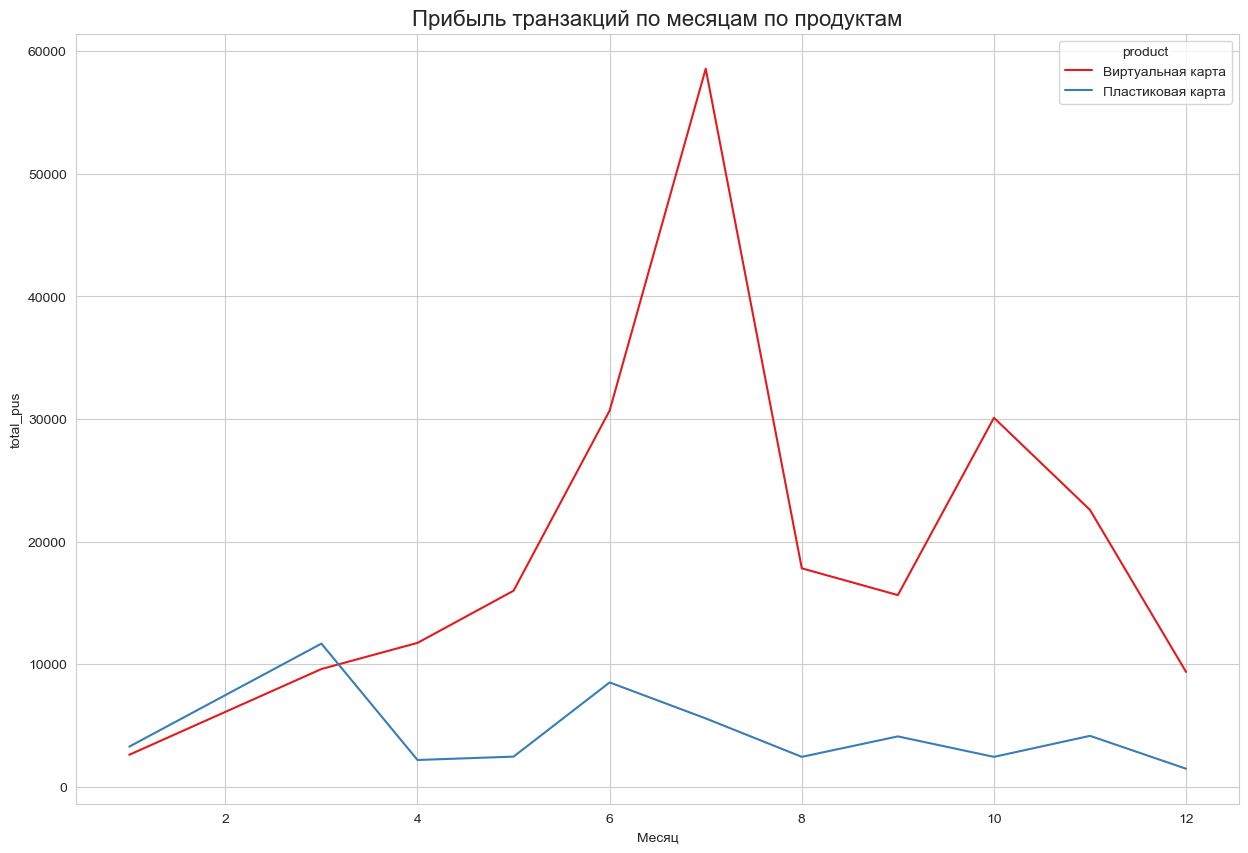

In [468]:
plt.figure(figsize=(15,10))

sns.lineplot(data=graf_rev_month, x='Месяц', y='total_pus', hue='product', palette = "Set1")

plt.title('Прибыль транзакций по месяцам по продуктам', size=16)
plt.savefig('Прибыль транзакций по месяцам по продуктам.svg')

### Средний платеж по месяцам

In [519]:
avg_amount_month = segments.groupby('number_month', as_index=False) \
    .agg({'amount' : 'mean'})

In [716]:
segments[segments['month'] == '2022-09'].value_counts('product')

product
QW                   45218
Виртуальная карта     3403
Пластиковая карта     2708
dtype: int64

In [715]:
segments[segments['month'] == '2022-10'].value_counts('product')

product
QW                   91607
Виртуальная карта     6801
Пластиковая карта     5294
dtype: int64

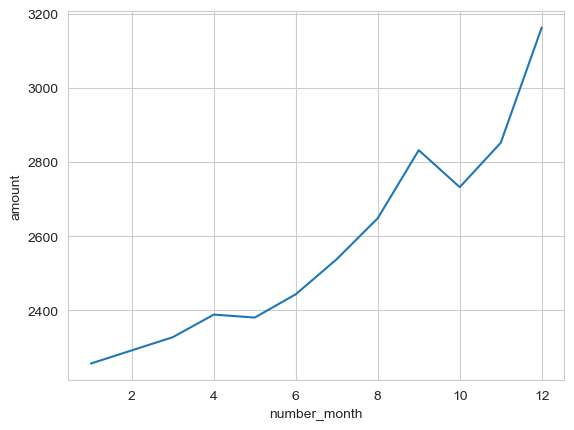

In [542]:
sns.lineplot(data=avg_amount_month, x='number_month', y='amount')

plt.savefig('avg_amount_month.svg')

In [518]:
normal_test = []
for i in segments[['amount', 'client_fee', 'payout_fee', 'interchange_fee', 'paysys_fee', 'payin_fee']]:
    shap = shapiro(segments[i])
    if shap.pvalue < 0.05:
        normal_test.append(shap)
    else:
        continue
        
normal_test

C:\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


[ShapiroResult(statistic=0.22333204746246338, pvalue=0.0),
 ShapiroResult(statistic=0.1440855860710144, pvalue=0.0),
 ShapiroResult(statistic=0.06676411628723145, pvalue=0.0),
 ShapiroResult(statistic=0.02460038661956787, pvalue=0.0),
 ShapiroResult(statistic=0.027904808521270752, pvalue=0.0),
 ShapiroResult(statistic=0.12835001945495605, pvalue=0.0)]

### Сколько юзеров снимают и пополняют

In [1016]:
type_qw = main_df.groupby('txn_type', as_index=False) \
    .agg({'qw' : 'nunique'})

In [1028]:
type_qw

,txn_type,qw
0,payin,218103
1,payout,287168


In [1032]:
type_qw.qw.pct_change()

0         NaN
1    0.316662
Name: qw, dtype: float64

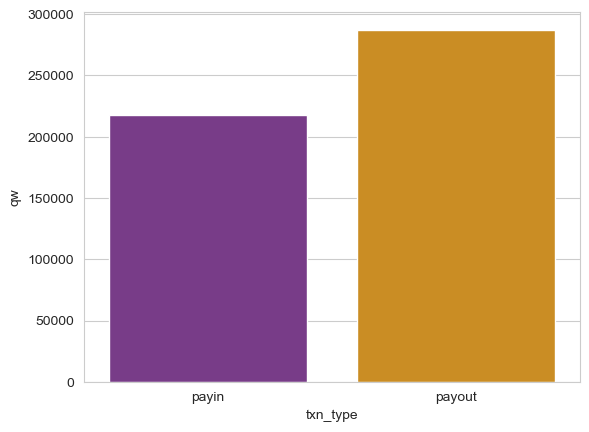

In [1034]:
sns.barplot(data=type_qw, x="txn_type", y="qw", palette='CMRmap')
plt.savefig('type_qw.svg')